# Read everything in

In [1]:
import pysis as ps
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import occultationFuncs as oF
from config import *
import sys

# hard coding outdir for this notebook
outdir = "outputs/testing/"

# Welcome Message
print("\nBeginning analysis of "+occname+"\n")

  #####################
  #     READ IN DATA  #
  #####################

# Get cube-size and allocate space
shape    = ps.CubeFile(cubdir+cubfiles[0]).shape
if visible:
  print("Visible and IR cubes")
  ncubs    = np.int64(len(cubfiles)/2)
  nspec    = shape[0] + ps.CubeFile(cubdir+cubfiles[1]).shape[0]
else:
  print("IR cubes")
  ncubs    = len(cubfiles)
  nspec    = shape[0]
height   = shape[1]
width    = shape[2]
maxpix   = np.max((height,width))
# Read in data, or load from save file
try:
  cubdata = np.load(outdir+"/"+occname+"data.npy")
  print("loaded previous save file")
except:
  cubdata = oF.readVIMSimaging(cubdir, cubfiles, ncubs, nspec, height, width, visible)
  np.save(outdir+"/"+occname+"data.npy", (cubdata))

# Get pixel dimensions
if ps.CubeFile(cubdir+cubfiles[0]).label['IsisCube']['Instrument']['SamplingMode'] == 'HI-RES':
  Xpixelwidth = 0.243 # mr
  Zpixelwidth = 0.5  # mr
  flatfield   = ps.CubeFile(flatdir+"ir_hires_flatfield_v0002.cub").data
  mode        = "HiRes"
  print("High-Resolution Frames")
else:
  Xpixelwidth = Zpixelwidth = 0.5 # mr
  flatfield   = ps.CubeFile(flatdir+"ir_flatfield_v0002.cub").data
  mode        = "LoRes"
  print("Low-Resolution Frames")

# read in prf scans and compute metric
Xmetrics,Zmetrics = oF.prfmetric('../data/PRFscans/makePRF270.sav', pixelSize=(Xpixelwidth,Zpixelwidth), Plots=prfplots, outdir='outputs/PRFscanplots/')

/data/vimsSaturnOccs/slapvisos/venv/lib/python3.11/site-packages/pysis/env.py:33: RuntimeWarning: Could not find isis. Is `ISISROOT` set?
  warnings.warn('Could not find isis. Is `ISISROOT` set?', RuntimeWarning)



Beginning analysis of AlpOri271S99

IR cubes
loaded previous save file
High-Resolution Frames


/data/vimsSaturnOccs/slapvisos/occultationFuncs.py:228: RuntimeWarning: divide by zero encountered in scalar divide
  lfty1 = Xscans[lftbnd,j,0] + (1-Rights[lftbnd,j])*(Xscans[lftbnd,j,0] - Xscans[lftbnd2,j,0])/ \


In [2]:
smoothmono, maxcoords, Xbrights, Xcompares, Zbrights, Xtransitions, Zscan, Zcorr, Xscan, Xcorr, scanmetrics, imagemetrics, comparisons, rows, columns, compares, imagemetric, fluxcal1pix, fluxcal2pix, bgflux = oF.findthestar(cubdata, (100,120), Xmetrics, Zmetrics, window=20, windowclip=10, metriccutoff=0.001, sigclip=5000)

smoothing input data over spectral window
taking the rolling average
finding the brightest pixels in each frame
finding the transition frames in X
finding which Zscan to use for each frame
Z centering
finding which Xscans to use
X centering
[0.01190154 0.01190154 0.01190154 ... 0.01190154 0.01190154 0.01190154] [12.63464451 12.63464451 12.63464451 ... 12.63464451 12.63464451
 12.63464451]
[[0.11526809]
 [0.1912833 ]
 [0.1912833 ]
 ...
 [0.01190154]
 [0.01190154]
 [0.0373343 ]]


/data/vimsSaturnOccs/slapvisos/occultationFuncs.py:888: RuntimeWarning: divide by zero encountered in divide
  imagemetrics = compix/bripix


In [34]:
#background = np.loadtxt("background.csv", delimiter=',')
#smoothmono -= background
columns.shape
rows.shape

(1504, 1, 16)

In [4]:
linex = np.linspace(0,len(smoothmono),len(smoothmono)*3)
liney = (slope/250) * linex + ((offset)/0.25)
crudephotometry = smoothmono[:,1:3,1:].sum(axis=2).sum(axis=1)
#realphotometry  = smoothmono.sum(axis=1)[:,1:3,1:].sum(axis=1)/fluxcal2pix
realphotometry = np.zeros(len(smoothmono))
smoothcal      = oF.rolling_average(fluxcal2pix, 25)
for i in range(len(realphotometry)):
    realphotometry[i] = smoothmono[i, np.max((0, Zbrights[i]-1)):np.min((smoothmono.shape[1]-1, Zbrights[i]+1)), np.max((1,Xbrights[i]-1)):np.min((smoothmono.shape[2]-1, Xbrights[i]+1))].sum() / smoothcal[i]#fluxcal2pix[i]

#leftrightcolors = [None]*len(Xbrights)
#for i in range(len(Xbrights)):
#    if Xbrights[i] == -1:
#        leftrightcolors[i] = 'red'
#    else:
#        leftrightcolors[i] = 'blue'

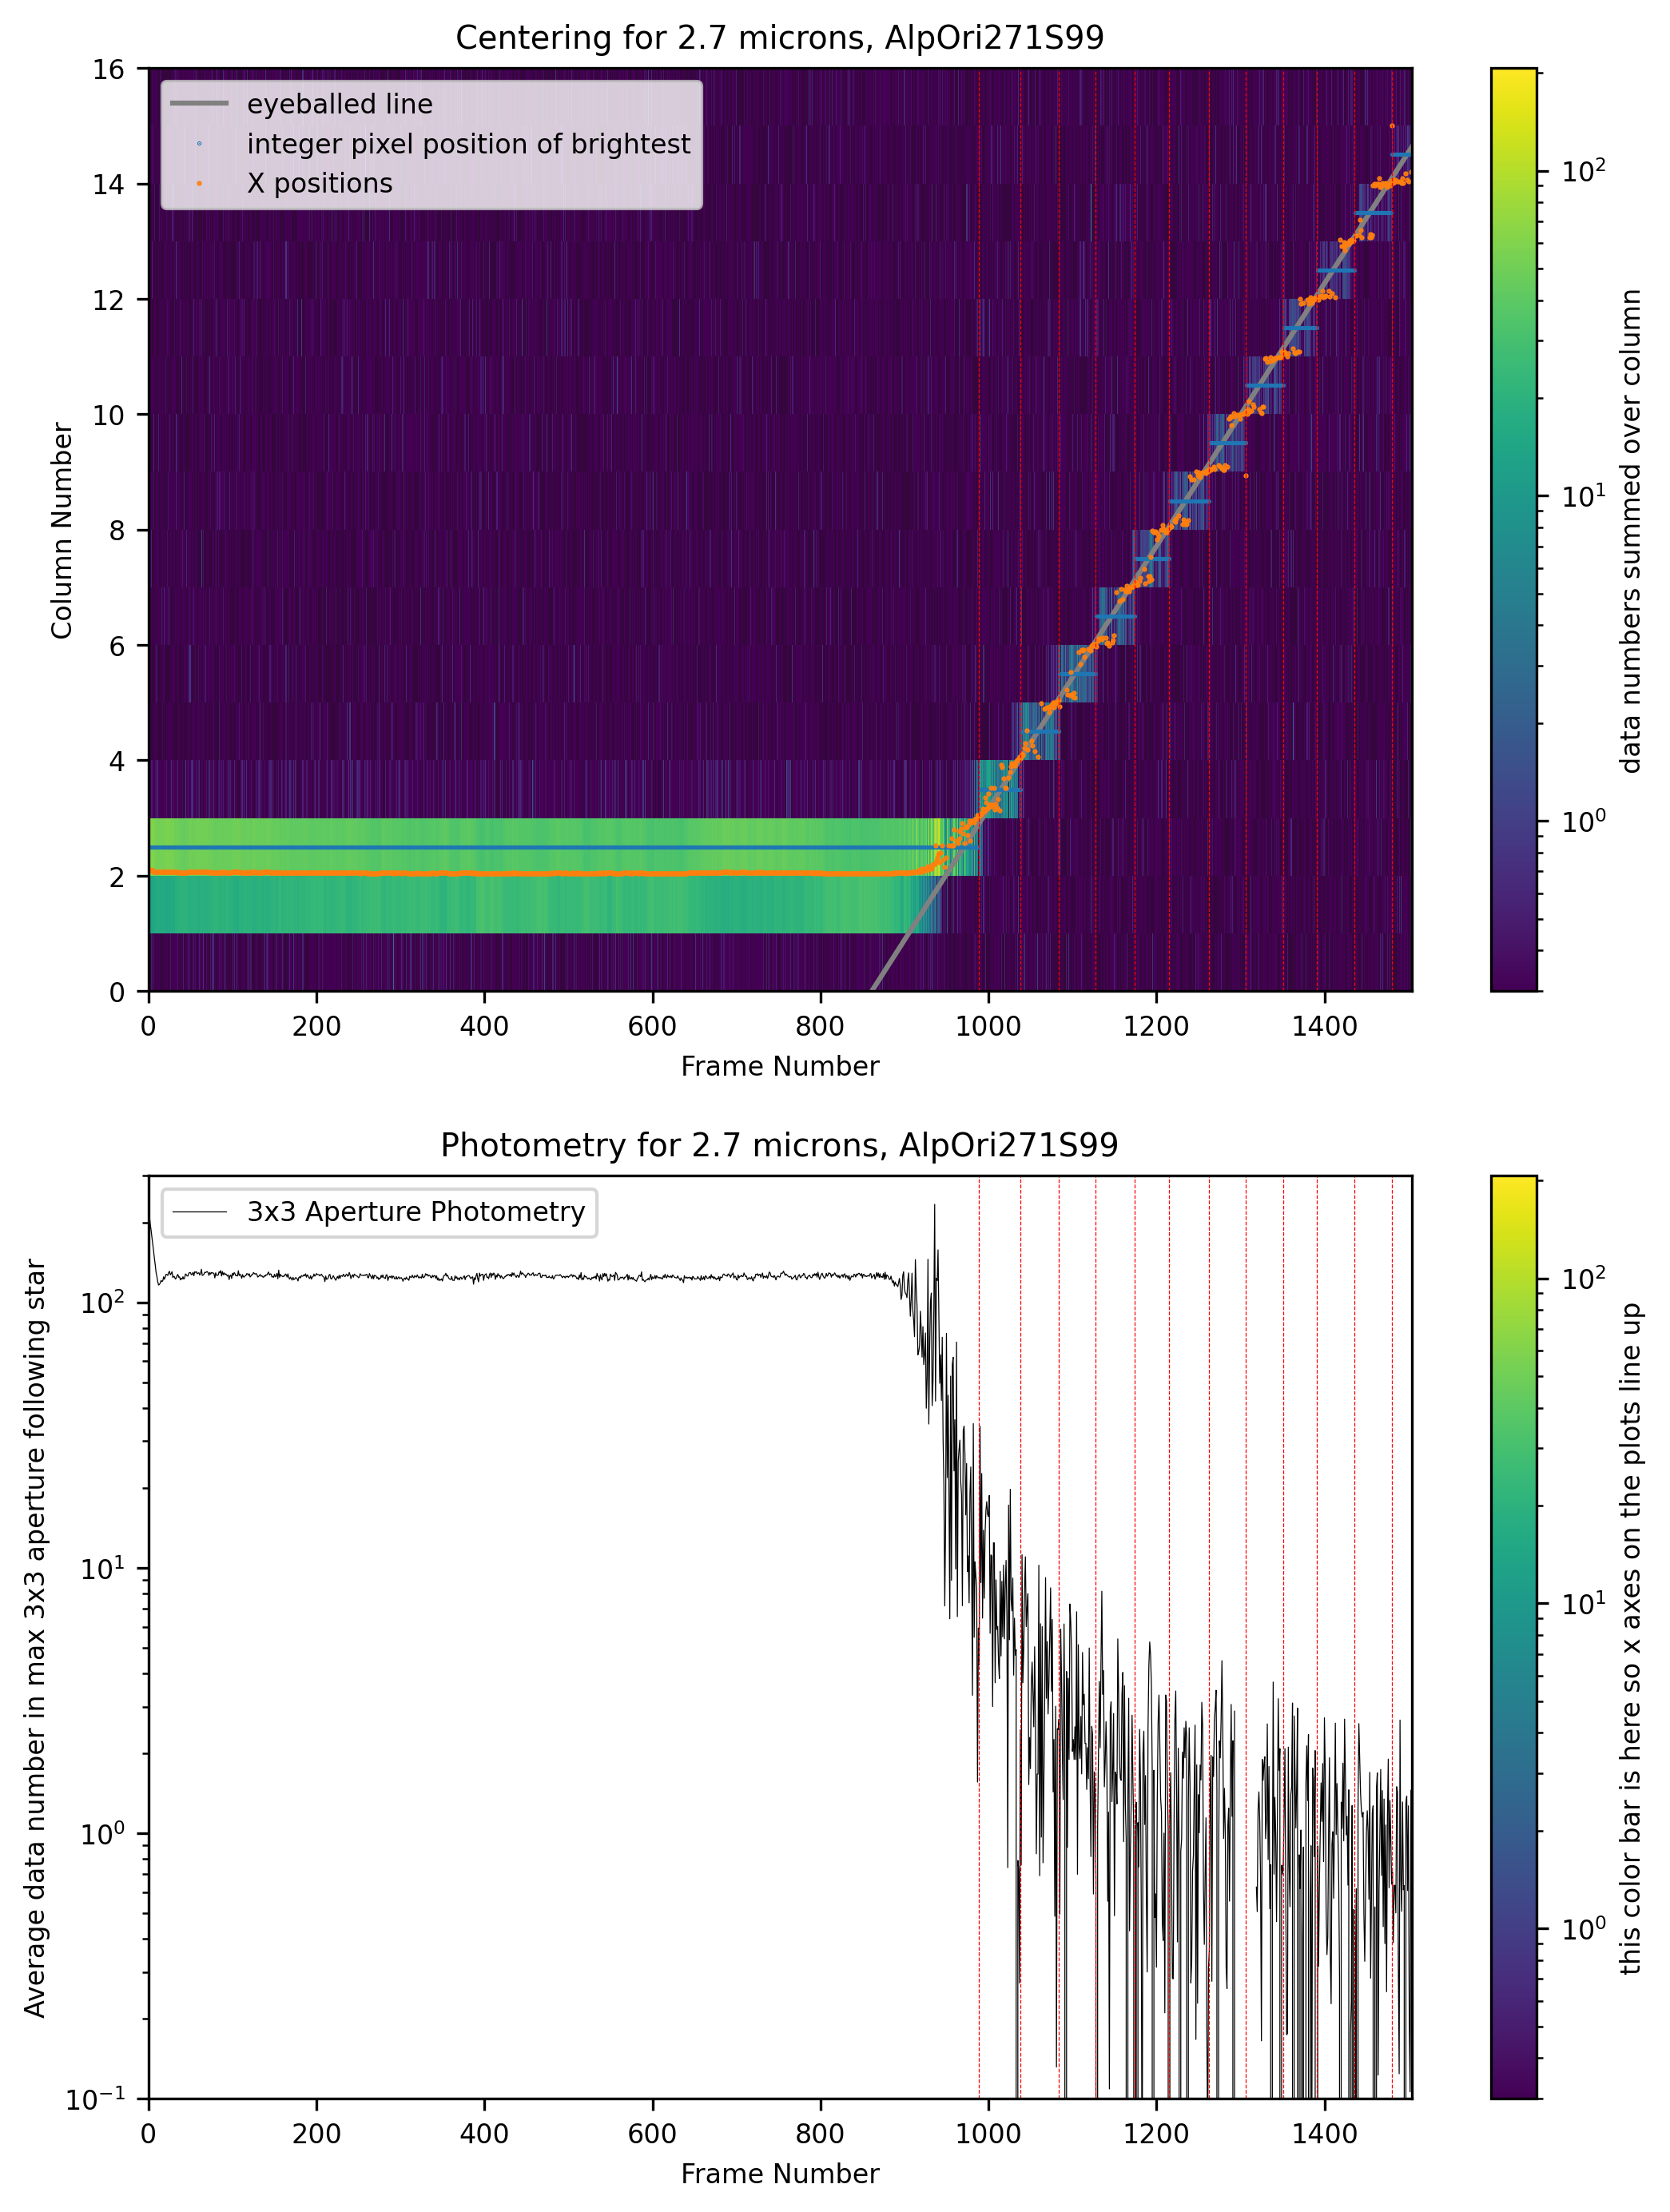

In [51]:
plt.rcParams.update({'font.size': 8})
fig, axs = plt.subplots(figsize=(8.5,11), dpi=300, nrows=2, ncols=1)
axs[0].plot(linex, liney, 'gray', label='eyeballed line')
#axs[0].plot(Zbrights + Zcorr, '.', markersize=1, label='Z positions')
axs[0].plot(Xbrights+0.5, '.', markersize=0.5, label='integer pixel position of brightest')
axs[0].plot(Xbrights + Xcorr, '.', markersize=1, label='X positions')
for i in range(len(Xtransitions)):
  axs[0].axvline(Xtransitions[i,0],0,15, color='red', linestyle='dashed', linewidth=0.3)
axs[0].set_title("Centering for 2.7 microns, " + occname)
axs[0].set_ylabel("Column Number")
axs[0].set_xlabel("Frame Number")
axs[0].legend(loc='upper left')
im = axs[0].imshow(rows[:,0,:].transpose(), aspect="auto", norm="log", interpolation="none", vmin=0.3, origin="lower", extent=(0,smoothmono.shape[0],0,smoothmono.shape[2]))
axs[0].set_facecolor('xkcd:dark purple')
fig.colorbar(im, ax=axs[0], label="data numbers summed over column")

axs[1].plot(realphotometry, 'k', linewidth=0.3, label='3x3 Aperture Photometry')
for i in range(len(Xtransitions)):
  axs[1].axvline(Xtransitions[i,0],0,1, color='red', linestyle='dashed', linewidth=0.3)
axs[1].set_yscale("log")
axs[1].set_title("Photometry for 2.7 microns, " + occname)
axs[1].set_ylabel("Average data number in max 3x3 aperture following star")
axs[1].set_xlabel("Frame Number")
axs[1].legend()
axs[1].set_ylim(1e-1,3e2)
axs[1].set_xlim(0,len(realphotometry))
#axs[1].plot(fluxcal2pix, label=f"2 pixel comparison")
#im = axs[1].imshow(smoothmono.max(axis=2).transpose(), aspect="auto", norm="log", interpolation="none", vmin=0.3, origin="lower", extent=(0,smoothmono.shape[0],0,smoothmono.shape[1]))
#axs[1].set_facecolor('xkcd:dark purple')
fig.colorbar(im, ax=axs[1], label="this color bar is here so x axes on the plots line up")

fig.savefig(outdir + occname + "-log.png")

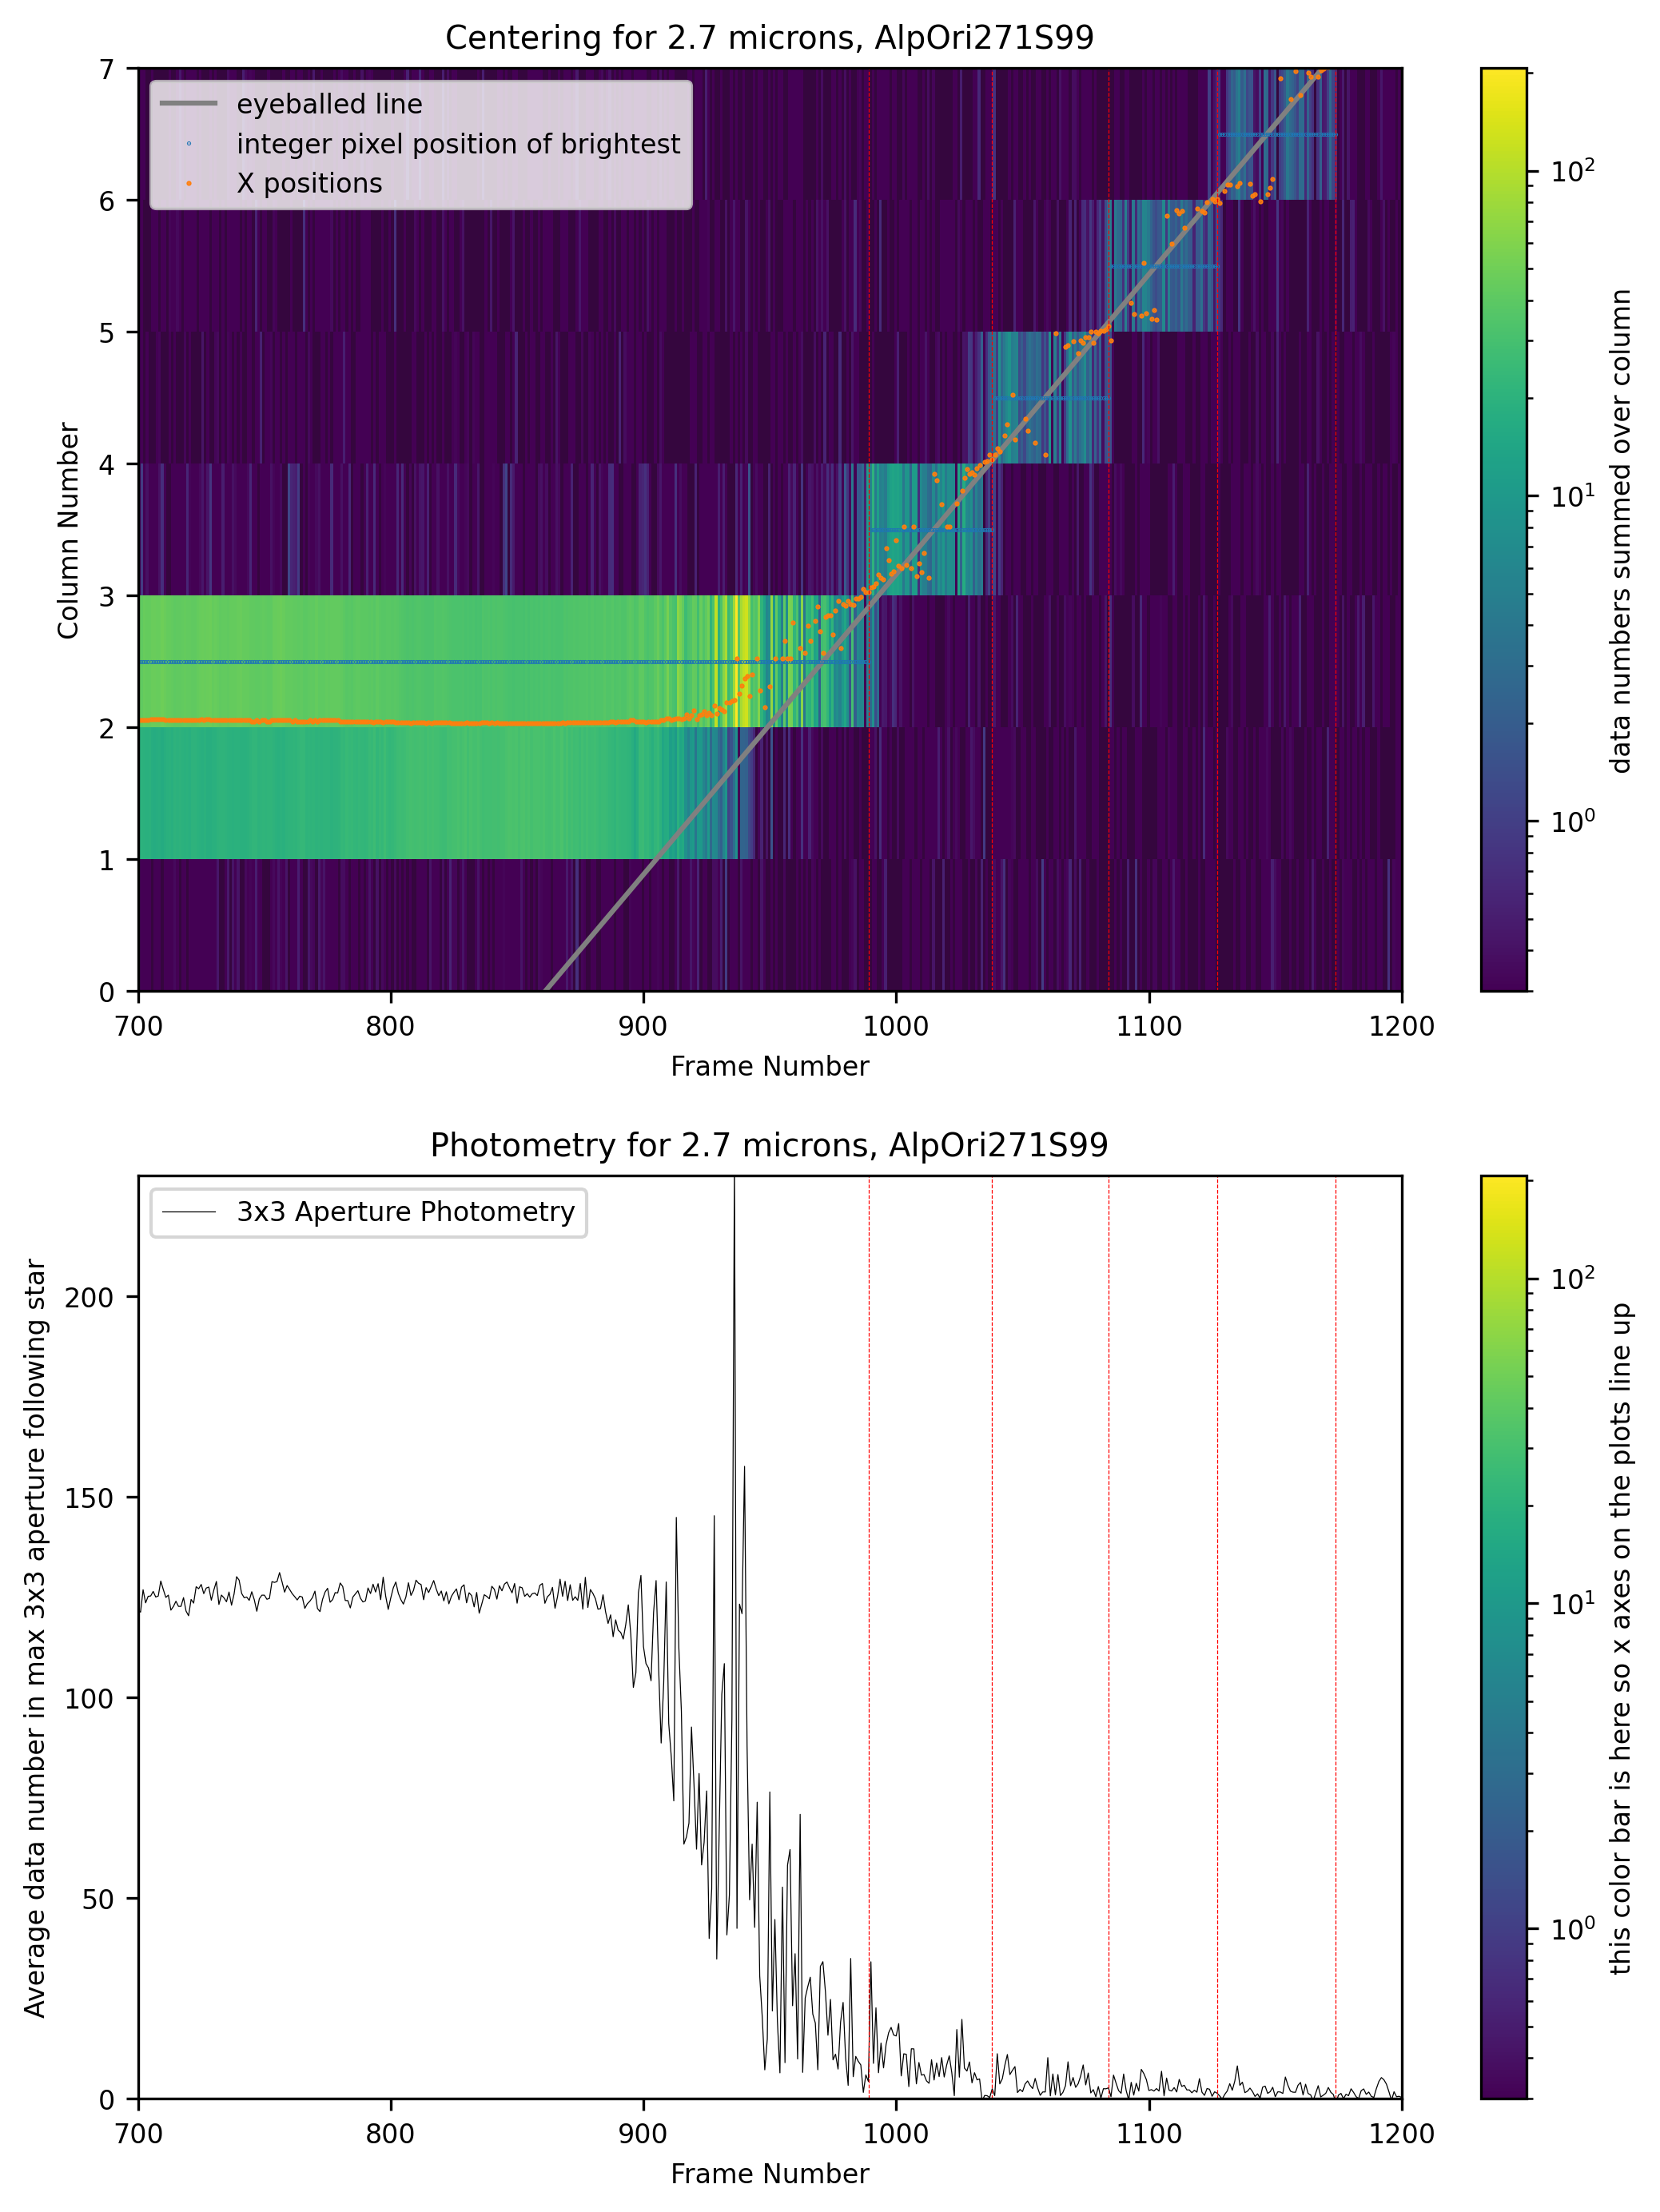

In [52]:
plt.rcParams.update({'font.size': 8})
fig, axs = plt.subplots(figsize=(8.5,11), dpi=300, nrows=2, ncols=1)
axs[0].plot(linex, liney, 'gray', label='eyeballed line')
#axs[0].plot(Zbrights + Zcorr, '.', markersize=1, label='Z positions')
axs[0].plot(Xbrights + 0.5, '.', markersize=0.5, label='integer pixel position of brightest')
axs[0].plot(Xbrights + Xcorr, '.', markersize=1, label='X positions')
axs[0].set_ylim(0,7)
axs[0].set_xlim(zoomin-100,zoomax)
#axs[0].set_xlim(0,zoomax)
for i in range(len(Xtransitions)):
  axs[0].axvline(Xtransitions[i,0],0,15, color='red', linestyle='dashed', linewidth=0.3)
axs[0].set_title("Centering for 2.7 microns, " + occname)
axs[0].set_ylabel("Column Number")
axs[0].set_xlabel("Frame Number")
axs[0].legend()
im = axs[0].imshow(rows[:,0,:].transpose(), aspect="auto", norm="log", interpolation="none", vmin=0.3, origin="lower", extent=(0,smoothmono.shape[0],0,smoothmono.shape[2]))
axs[0].set_facecolor('xkcd:dark purple')
fig.colorbar(im, ax=axs[0], label="data numbers summed over column")

axs[1].plot(realphotometry, 'k', linewidth=0.3, label='3x3 Aperture Photometry')
for i in range(len(Xtransitions)):
  axs[1].axvline(Xtransitions[i,0],0,1, color='red', linestyle='dashed', linewidth=0.3)
#axs[1].set_yscale("log")
axs[1].set_xlim(zoomin-100,zoomax)
#axs[1].set_xlim(0,zoomax)
#axs[1].set_xlim(950,1000)
axs[1].set_ylim(0,230)
#axs[1].set_ylim(130,170)
axs[1].set_title("Photometry for 2.7 microns, " + occname)
axs[1].set_ylabel("Average data number in max 3x3 aperture following star")
axs[1].set_xlabel("Frame Number")
axs[1].legend()
fig.colorbar(im, ax=axs[1], label="this color bar is here so x axes on the plots line up")


fig.savefig(outdir + occname + "-linear-zoom.png")

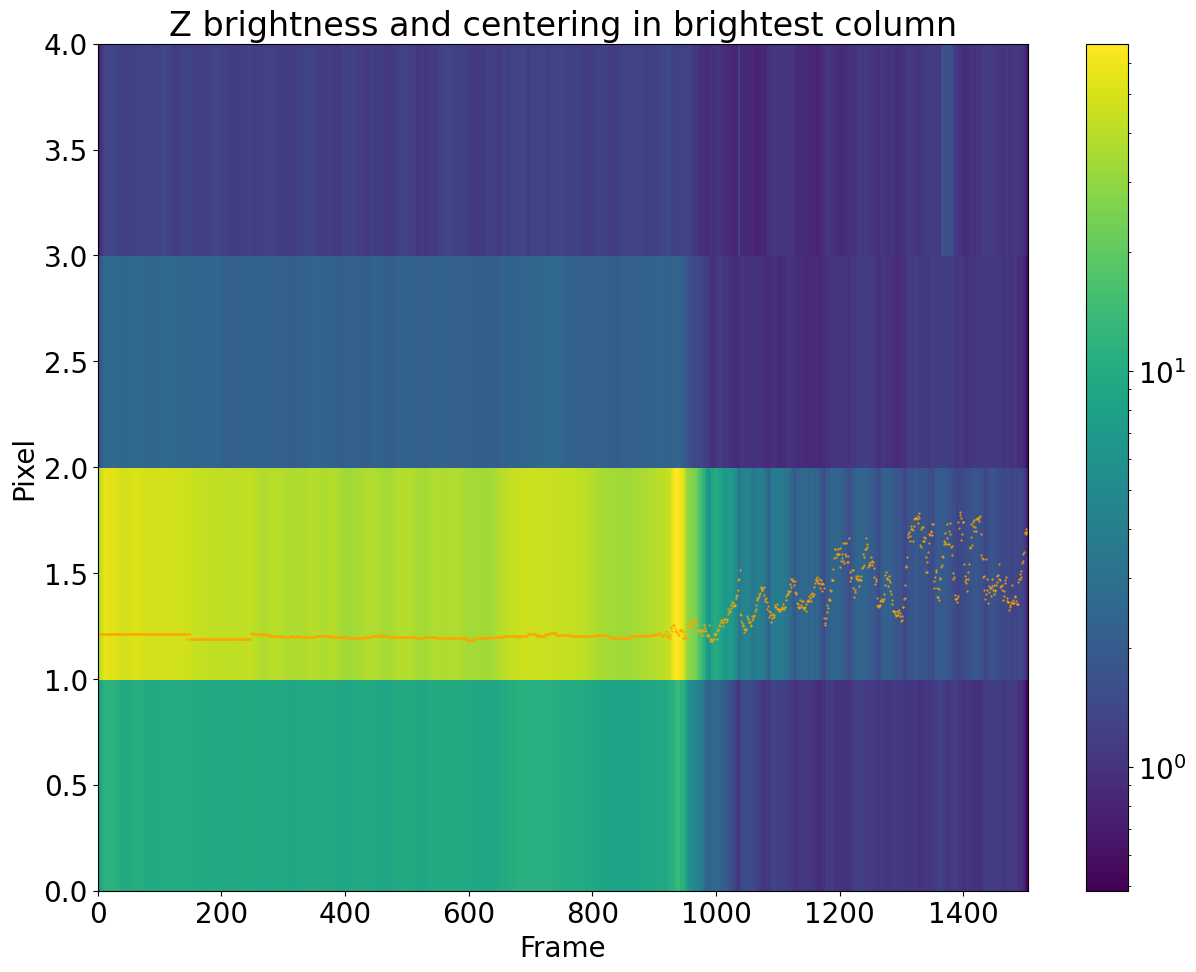

In [49]:
plt.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(15,11))
im = ax.imshow(columns[:,:,0].transpose(), aspect="auto", norm="log", interpolation="none", origin="lower", extent=(0,smoothmono.shape[0],0,smoothmono.shape[1]))
ax.set_facecolor('xkcd:dark purple')
ax.plot(Zbrights + Zcorr, '.', color="orange", markersize=1, label='Z positions')
ax.set_title("Z brightness and centering in brightest column")
ax.set_ylabel("Pixel")
ax.set_xlabel("Frame")
fig.colorbar(im)
fig.savefig(outdir + occname + "-Zcenters.png")

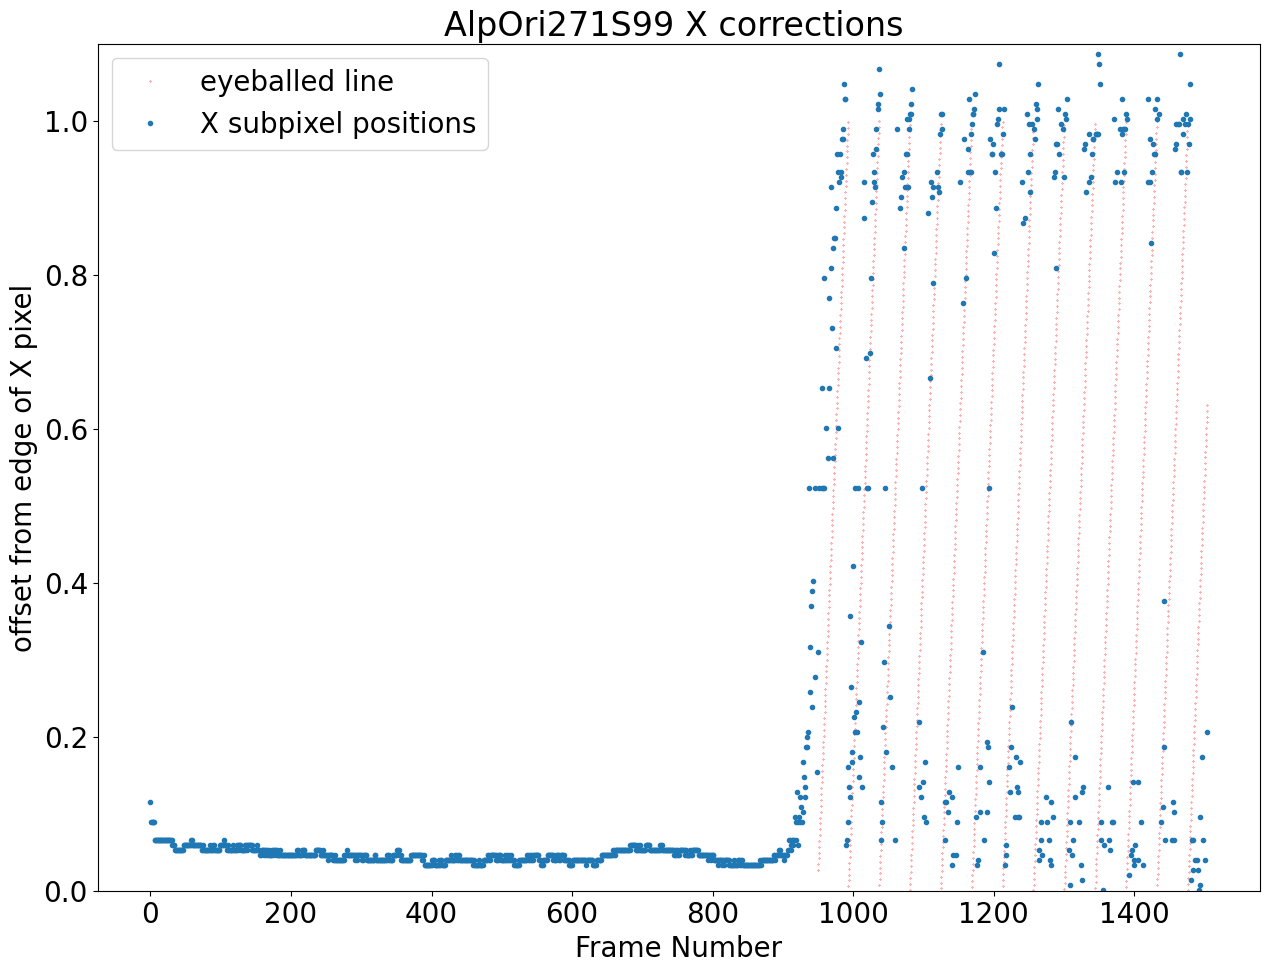

In [8]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,11))
plt.plot(linex[950*3:], liney[950*3:]%1, 'r.', markersize=0.5, label="eyeballed line")
plt.plot(Xcorr, '.', label='X subpixel positions')
plt.title(occname + " X corrections ")
plt.ylabel("offset from edge of X pixel")
plt.xlabel("Frame Number")
#plt.xlim(800,1500)
plt.ylim(0,1.1)
plt.legend(loc='upper left')
#plt.grid()
plt.savefig(outdir + occname + "-Xcorrections-addline.png")

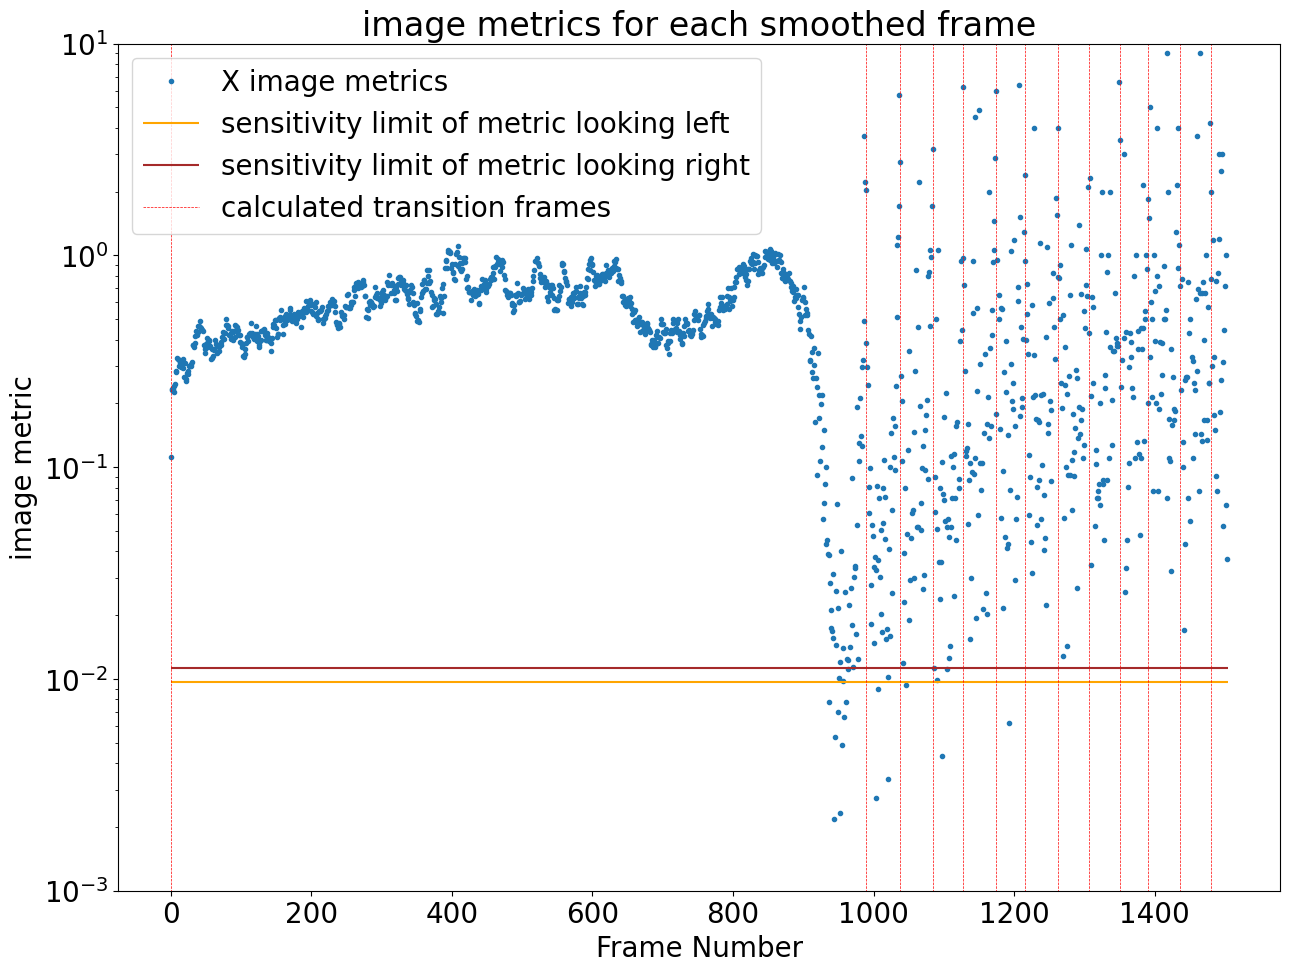

In [9]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,11))
plt.plot((abs(imagemetrics[:,0])), '.', label='X image metrics')
#plt.plot((imagemetric), '.', label='X image metrics')
#plt.xlim(700,1500)
plt.yscale("log")
plt.hlines(np.nanmin(Xmetrics[:,8:14,3]), 0, len(imagemetrics), color='orange', label="sensitivity limit of metric looking left")
plt.hlines(np.nanmin(Xmetrics[:,8:14,4]), 0, len(imagemetrics), color='brown', label="sensitivity limit of metric looking right")
plt.vlines(Xtransitions[:,0],0,10, color='red', linestyle='dashed', linewidth=0.5, label='calculated transition frames')
plt.ylim(1e-3,1e1)
plt.title("image metrics for each smoothed frame")
plt.ylabel("image metric")
plt.xlabel("Frame Number")
plt.legend(loc='upper left')
plt.savefig(outdir + occname + "-imagemetrics.png")

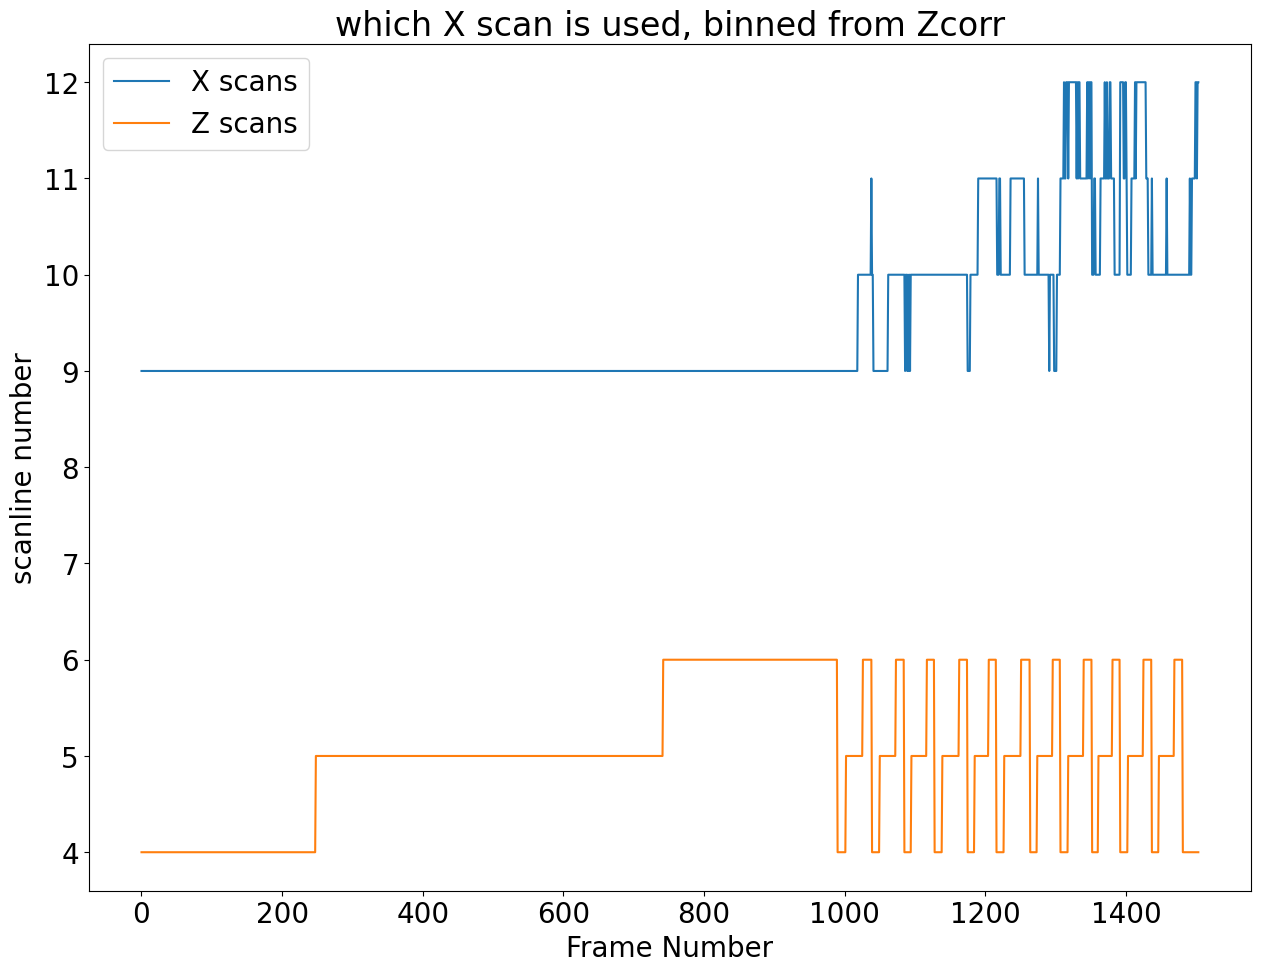

In [10]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,11))
plt.plot(Xscan, label="X scans")
plt.plot(Zscan, label="Z scans")
plt.title("which X scan is used, binned from Zcorr")
plt.ylabel("scanline number")
plt.xlabel("Frame Number")
plt.legend(loc='upper left')
plt.savefig(outdir + occname + "-scans.png")

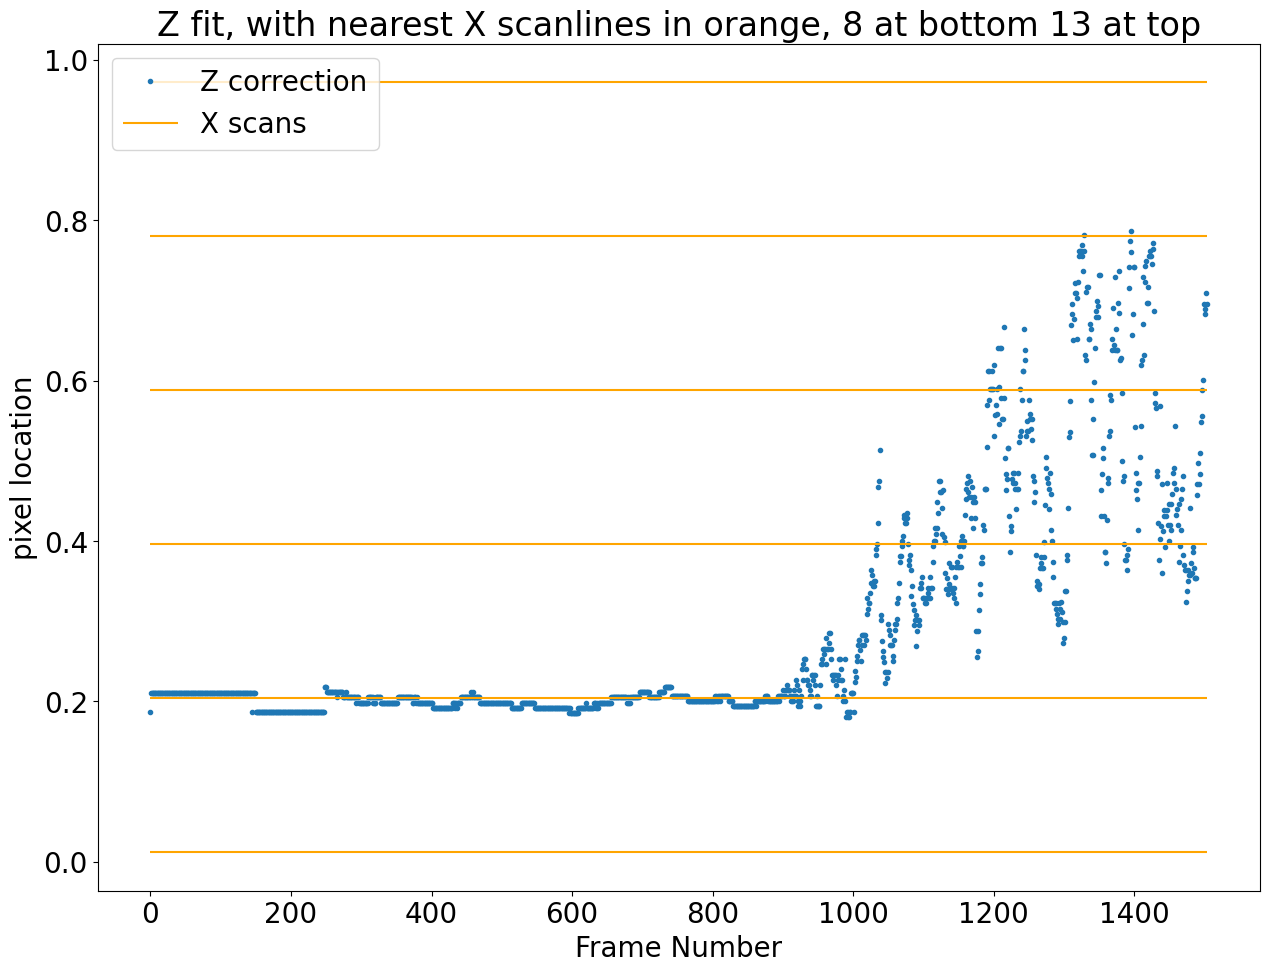

In [11]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,11))
plt.plot(Zcorr, '.', label="Z correction")
plt.hlines((Xmetrics[:,8:14,1].mean(axis=0) + 0.25)/0.5, 0, len(Zcorr), color='orange', label="X scans")
plt.title("Z fit, with nearest X scanlines in orange, 8 at bottom 13 at top")
plt.ylabel("pixel location")
plt.xlabel("Frame Number")
plt.legend(loc='upper left')
plt.savefig(outdir + occname + "-zcorrs.png")

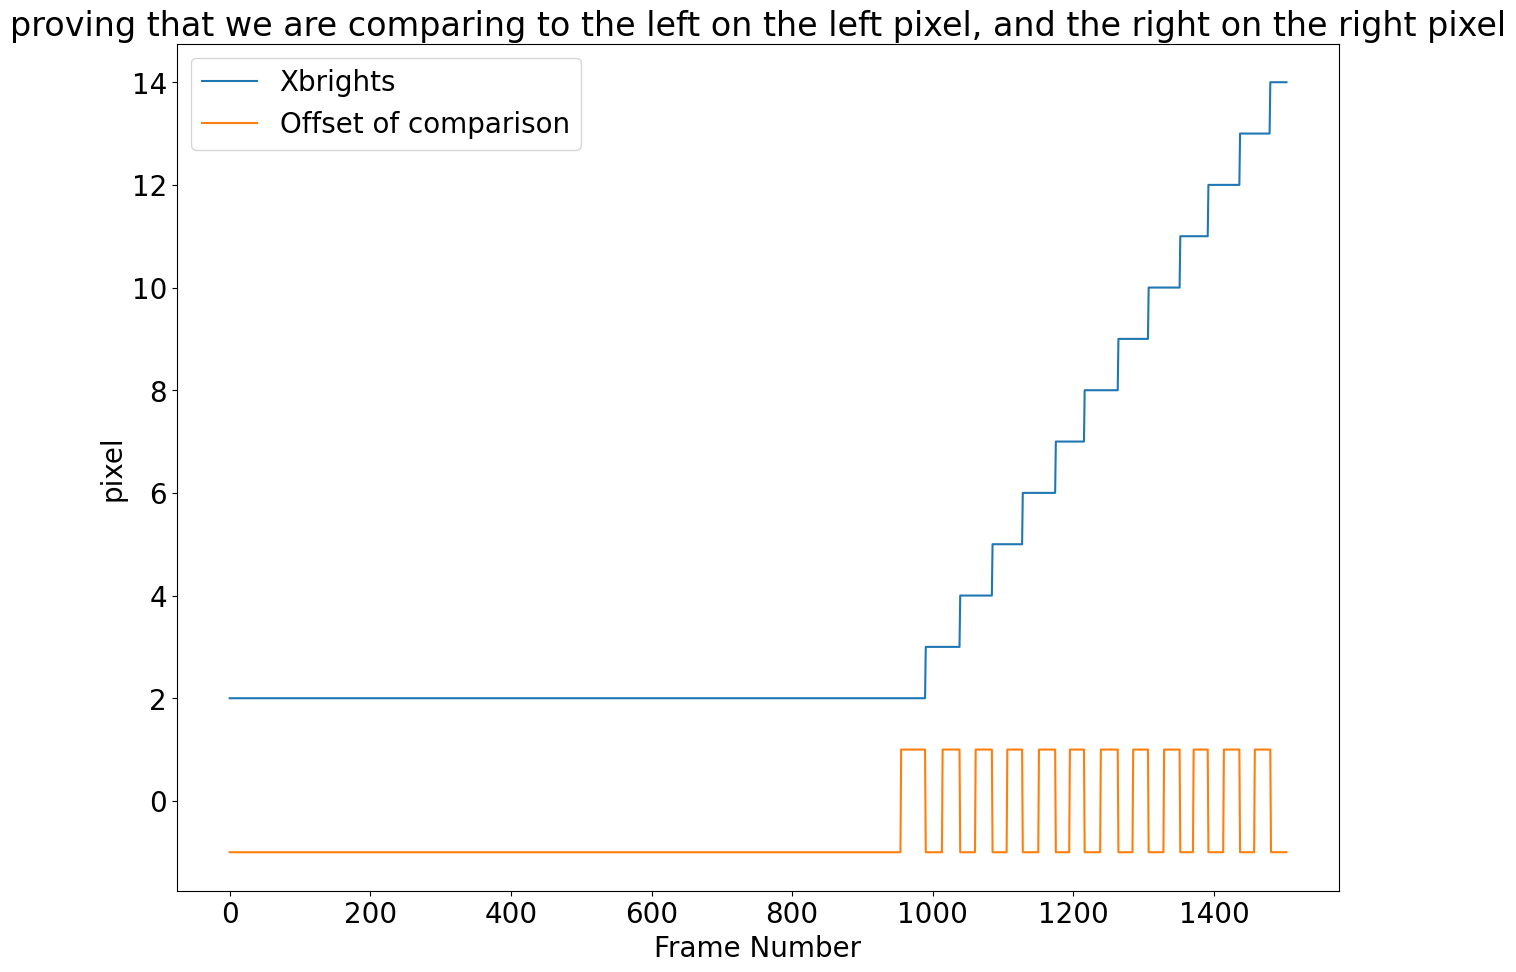

In [12]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,11))
plt.plot(Xbrights, label="Xbrights")
plt.plot(Xcompares, label="Offset of comparison")
plt.title("proving that we are comparing to the left on the left pixel, and the right on the right pixel")
plt.ylabel("pixel")
plt.xlabel("Frame Number")
plt.legend()
#plt.xlim(940,970)
plt.savefig(outdir + occname + "-brightsoffsets.png")

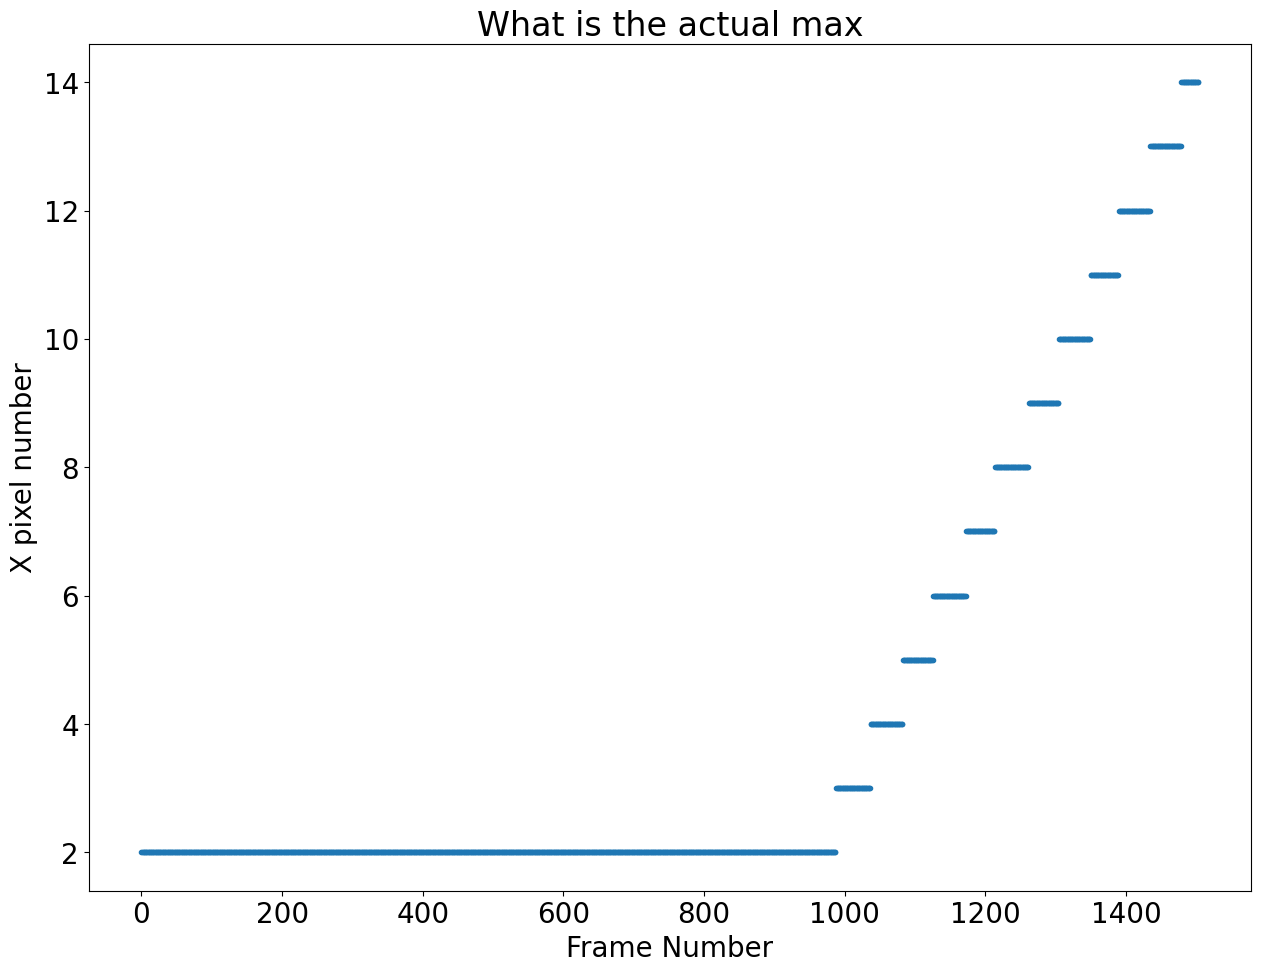

In [13]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,11))
plt.plot(maxcoords[1], '.')
plt.title("What is the actual max")
plt.ylabel("X pixel number")
plt.xlabel("Frame Number")
plt.savefig(outdir + occname + "-actuallybrightest.png")

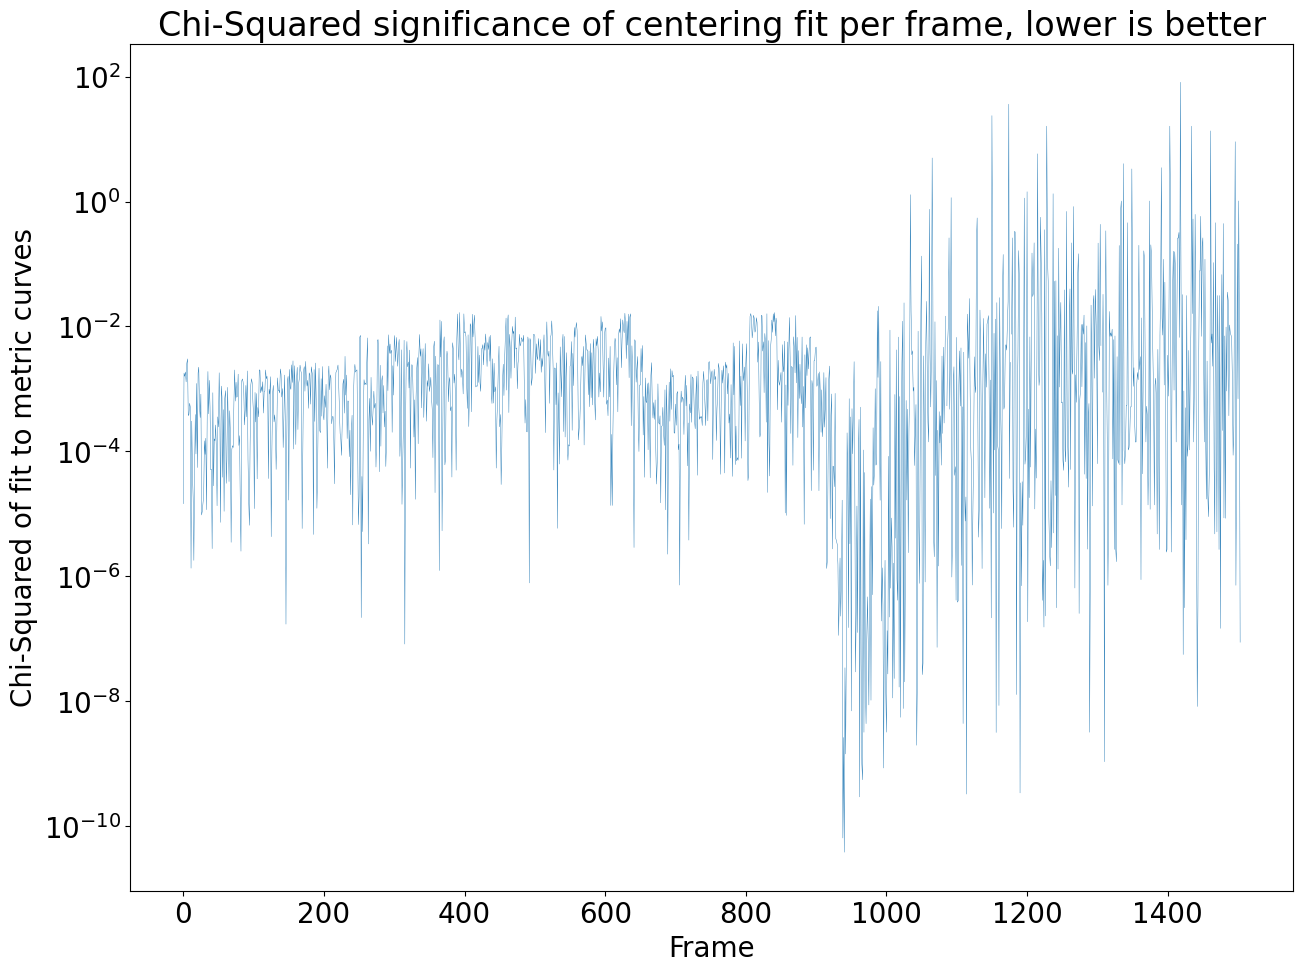

In [14]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,11))
plt.plot(np.nanmin(comparisons, axis=1), linewidth=0.3)
plt.yscale("log")
#plt.ylim(1e-5, 1e1)
plt.ylabel("Chi-Squared of fit to metric curves")
plt.xlabel("Frame")
plt.title("Chi-Squared significance of centering fit per frame, lower is better")
plt.savefig(outdir + occname + "-centeringsignificance.png")

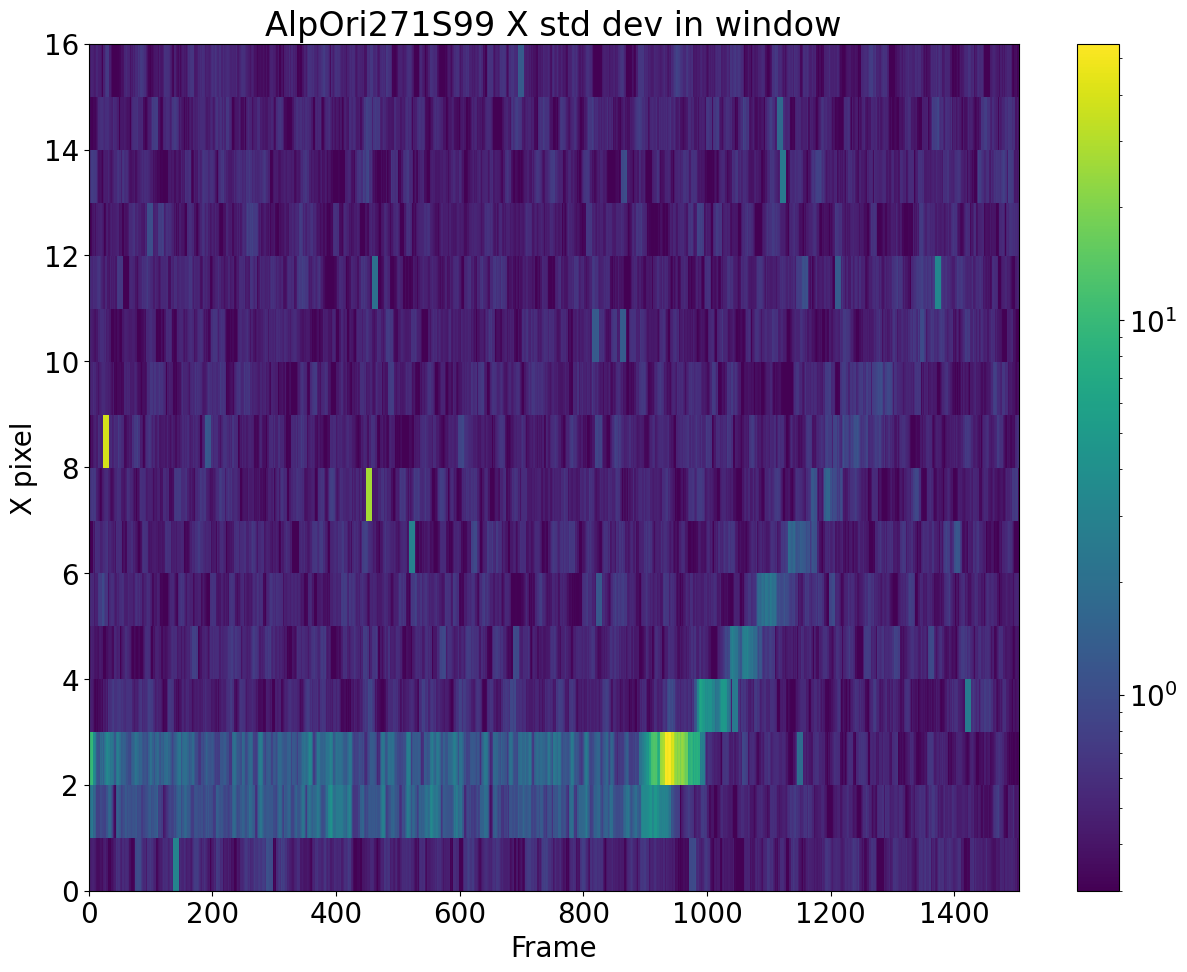

In [15]:
plt.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(15,11))
Xstds = [oF.rolling_std(smoothmono.sum(axis=1)[:,i], 5, axis=0).transpose() for i in range(smoothmono.shape[2])]
Xstdim = np.stack(Xstds, axis=1)
im = plt.imshow(Xstdim.transpose(), aspect="auto", norm="log", interpolation="none", origin="lower", vmin=0.3, extent=(0,smoothmono.shape[0],0,smoothmono.shape[2]))
ax.set_facecolor('xkcd:dark purple')
fig.colorbar(im, ax=ax)
ax.set_title(occname + " X std dev in window")
ax.set_ylabel("X pixel")
ax.set_xlabel("Frame")
fig.savefig(outdir + occname + "-stddevX.png")
#ax.set_yscale("log")

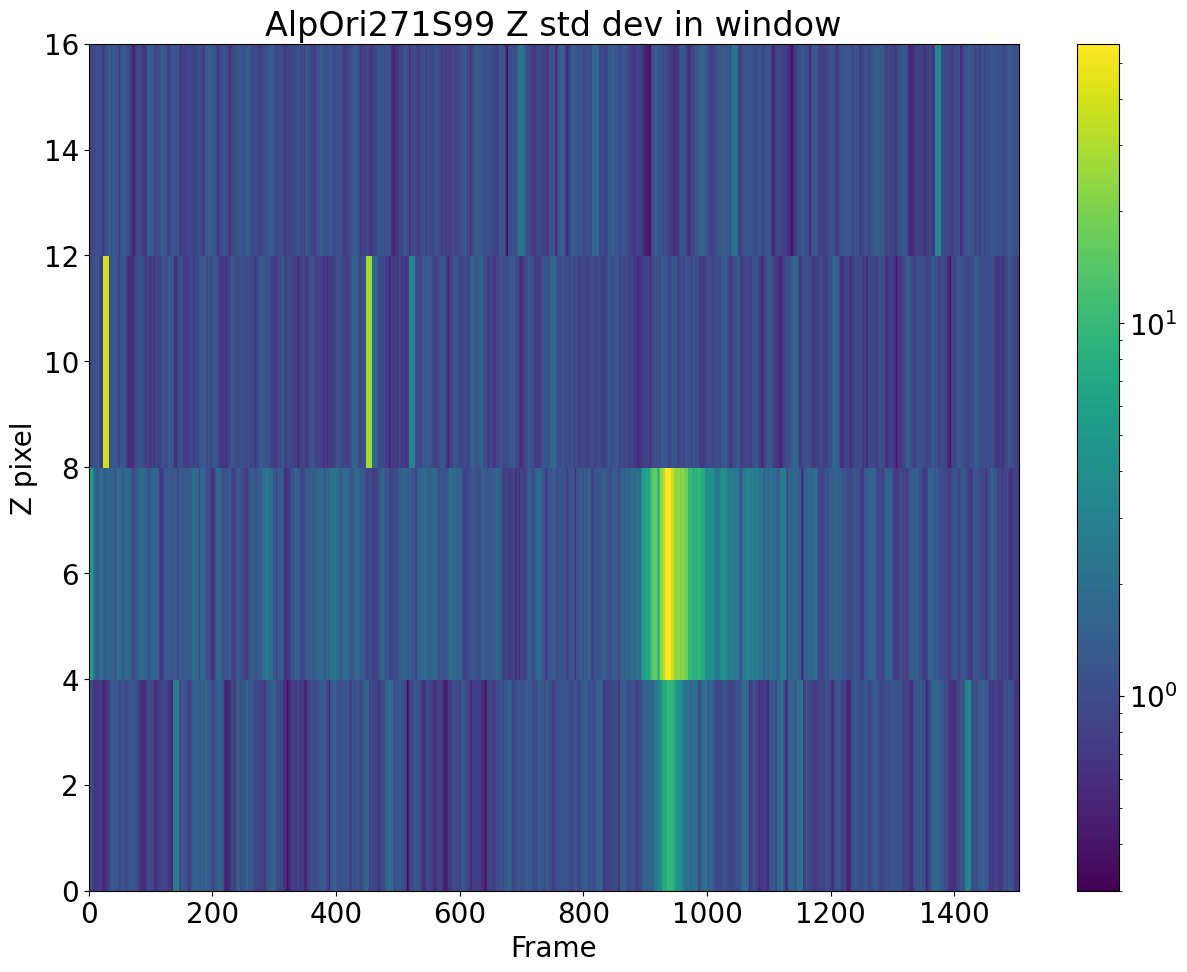

In [16]:
plt.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(15,11))
Zstds = [oF.rolling_std(smoothmono.sum(axis=2)[:,i], 5, axis=0).transpose() for i in range(smoothmono.shape[1])]
Zstdim = np.stack(Zstds, axis=1)
im = plt.imshow(Zstdim.transpose(), aspect="auto", norm="log", interpolation="none", origin="lower", vmin=0.3, extent=(0,smoothmono.shape[0],0,smoothmono.shape[2]))
ax.set_facecolor('xkcd:dark purple')
fig.colorbar(im, ax=ax)
ax.set_title(occname + " Z std dev in window")
ax.set_ylabel("Z pixel")
ax.set_xlabel("Frame")
fig.savefig(outdir + occname + "-stddevZ.png")

Two calibrations are (where PRF(value) is the relevant PRF scan evaluated at *value*):

fluxcal1pix = PRF(centeringvalue) / PRF(maxvalue) = Image(brightpixel) / ActualFlux
Solve for Actual Flux:
ActualFlux = Image(brightpixel)/fluxcal1pix

fluxcal2pix = (PRF(centeringvalue) * (1 + PRFMetric(centeringvalue)) / PRF(maxvalue) = (Image(brightpixel) + Image(comparepixel)) / ActualFlux
Remember that PRFMetric(centeringvalue) = PRF(centeringvalue + pixel shift)/PRF(centeringvalue) to prove that this equation holds.
Solve for ActualFlux:
ActualFlux = (Image(brightpixel) + Image(comparepixel)) / fluxcal2pix

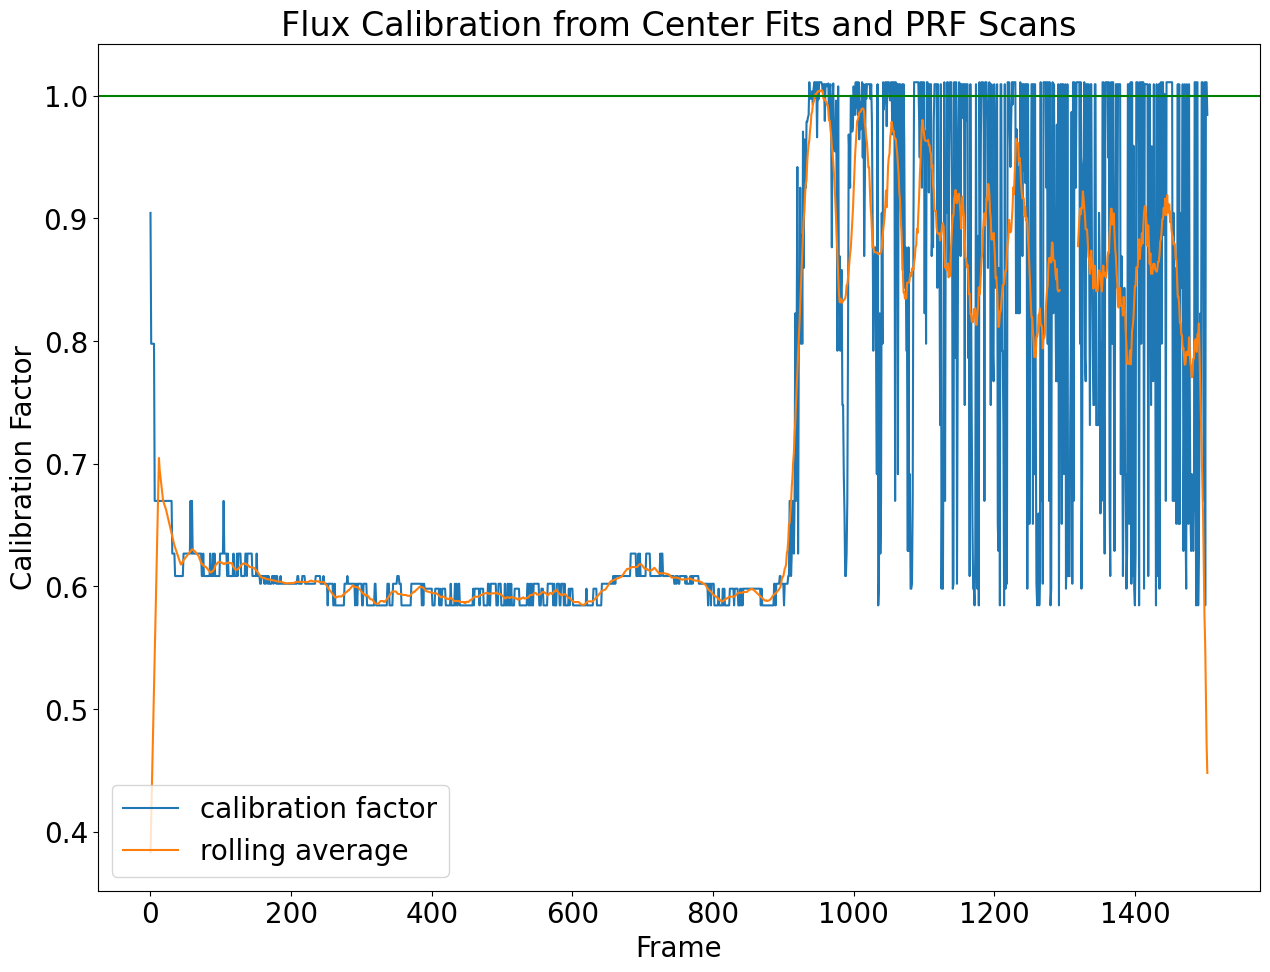

In [17]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,11))
#plt.plot(fluxcal1pix, 'g', label=f"1 pixel comparison")
#plt.plot(oF.rolling_average(smoothmono.sum(axis=1)[:,1:4].sum(axis=1), 1), 'b', label=f"pixel sum")
plt.plot(fluxcal2pix, label=f"calibration factor")
plt.plot(oF.rolling_average(fluxcal2pix, 25), label=f"rolling average")
plt.legend(loc="lower left")
#plt.ylim(-10,250)
#plt.ylim(140,180)
#plt.axhline(0,0,1500, color="orange")
plt.axhline(1,0,1500, color="green")
plt.ylabel("Calibration Factor")
plt.xlabel("Frame")
plt.title("Flux Calibration from Center Fits and PRF Scans")
plt.savefig(outdir + occname + "-fluxcalmethodscomparison.png")

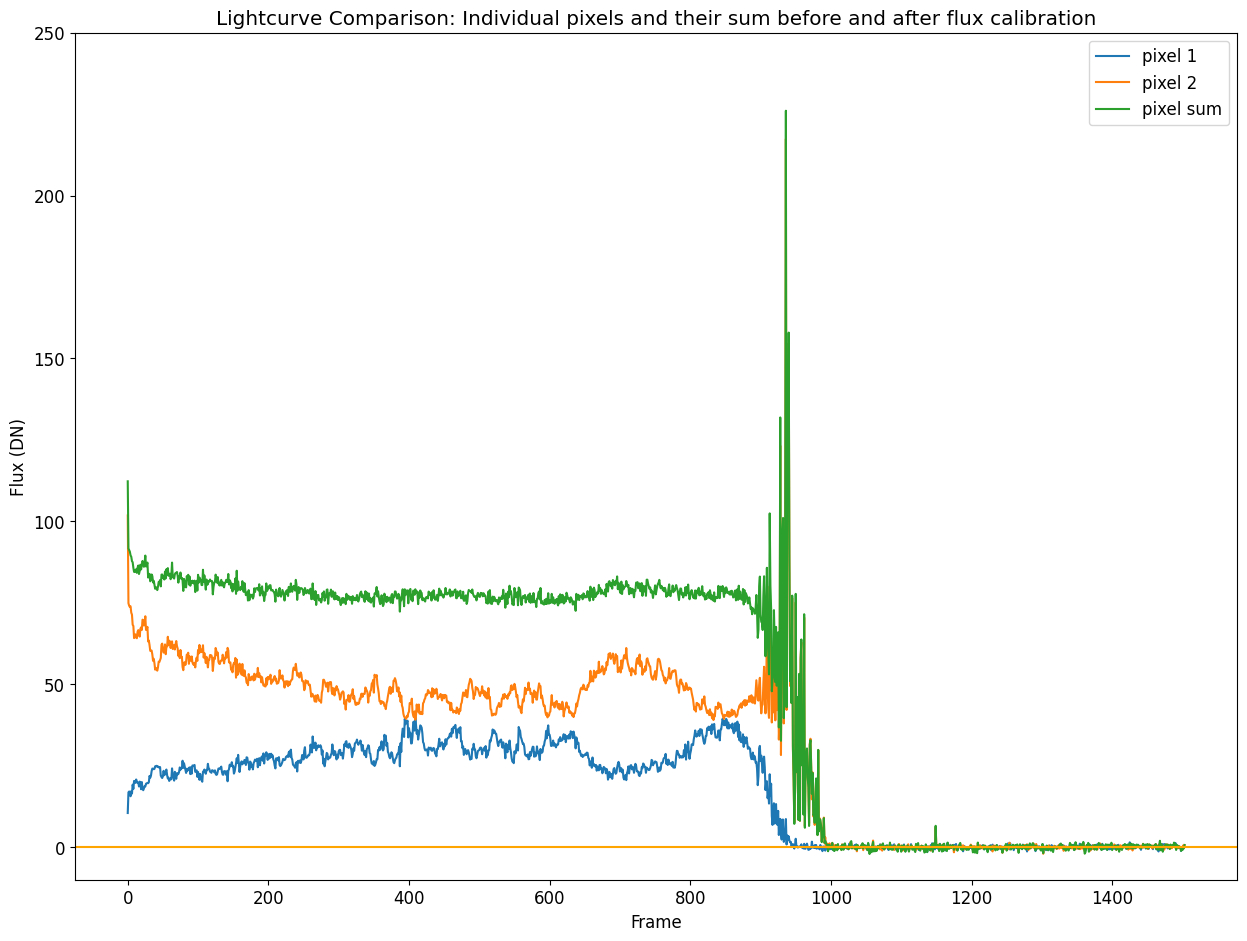

In [18]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(15,11))
[plt.plot(oF.rolling_average(smoothmono.sum(axis=1)[:,i], 1), label=f"pixel {i}") for i in range(1,3)]
plt.plot(oF.rolling_average(smoothmono.sum(axis=1)[:,1:3].sum(axis=1), 1), label=f"pixel sum")
#plt.plot(oF.rolling_average(smoothmono.sum(axis=1)[:,1:3].sum(axis=1)/fluxcal2pix, 1), label=f"pixel sum calibrated")
#plt.plot(oF.rolling_average(smoothmono.sum(axis=1)[:,2]/fluxcal1pix, 1), label=f"pixel 2 corrected")
#plt.plot(fluxcal*7)
plt.legend(loc="upper right")
plt.ylim(-10,250)
plt.axhline(0,0,1500, color="orange")
plt.ylabel("Flux (DN)")
plt.xlabel("Frame")
plt.title("Lightcurve Comparison: Individual pixels and their sum before and after flux calibration")
plt.savefig(outdir + occname + "-fluxmeasurements.png")

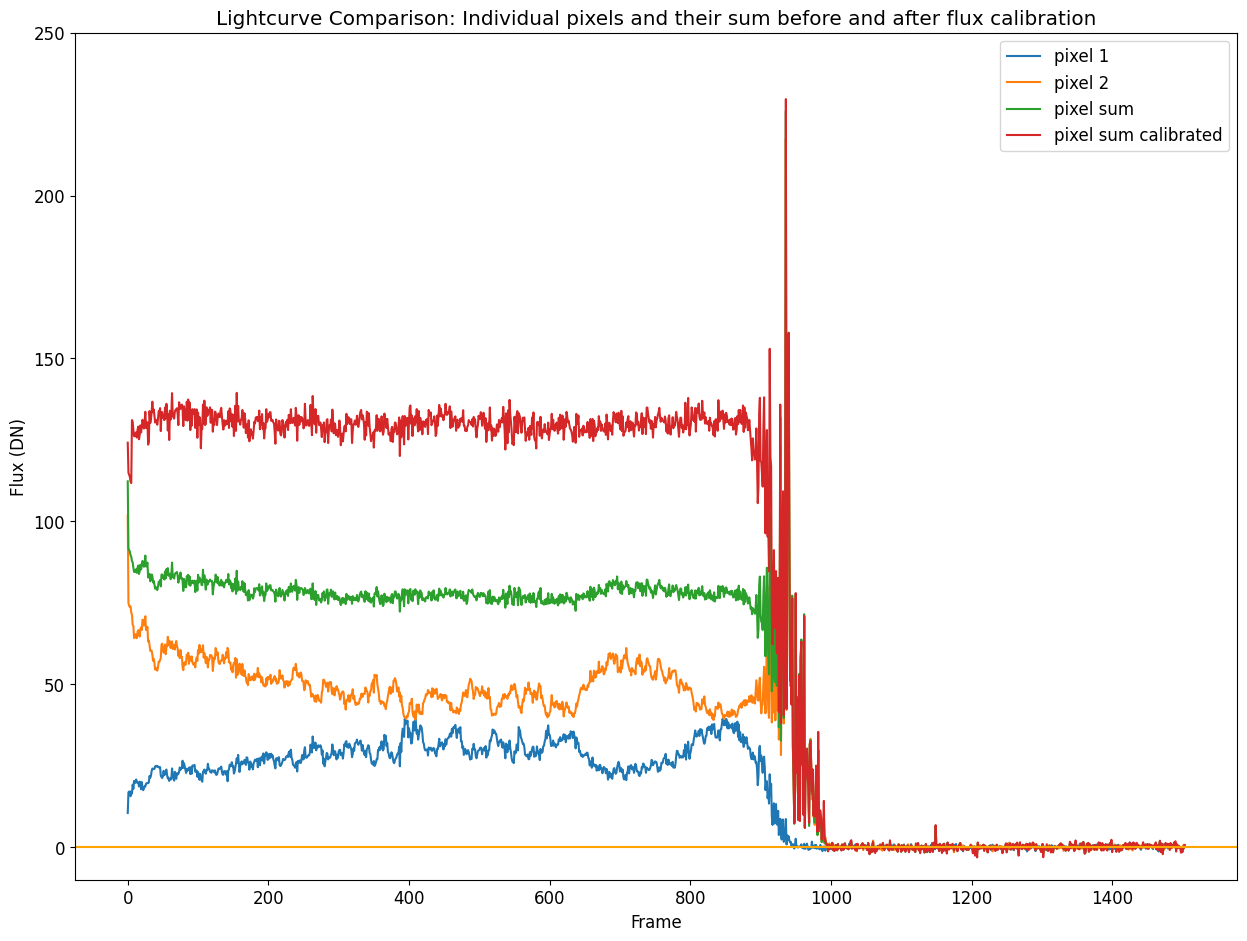

In [19]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(15,11))
[plt.plot(oF.rolling_average(smoothmono.sum(axis=1)[:,i], 1), label=f"pixel {i}") for i in range(1,3)]
plt.plot(oF.rolling_average(smoothmono.sum(axis=1)[:,1:3].sum(axis=1), 1), label=f"pixel sum")
plt.plot(oF.rolling_average(smoothmono.sum(axis=1)[:,1:3].sum(axis=1)/fluxcal2pix, 1), label=f"pixel sum calibrated")
#plt.plot(oF.rolling_average(smoothmono.sum(axis=1)[:,2]/fluxcal1pix, 1), label=f"pixel 2 corrected")
#plt.plot(fluxcal*7)
plt.legend(loc="upper right")
plt.ylim(-10,250)
plt.axhline(0,0,1500, color="orange")
plt.ylabel("Flux (DN)")
plt.xlabel("Frame")
plt.title("Lightcurve Comparison: Individual pixels and their sum before and after flux calibration")
plt.savefig(outdir + occname + "-fluxmeasurementsandcalibrations.png")

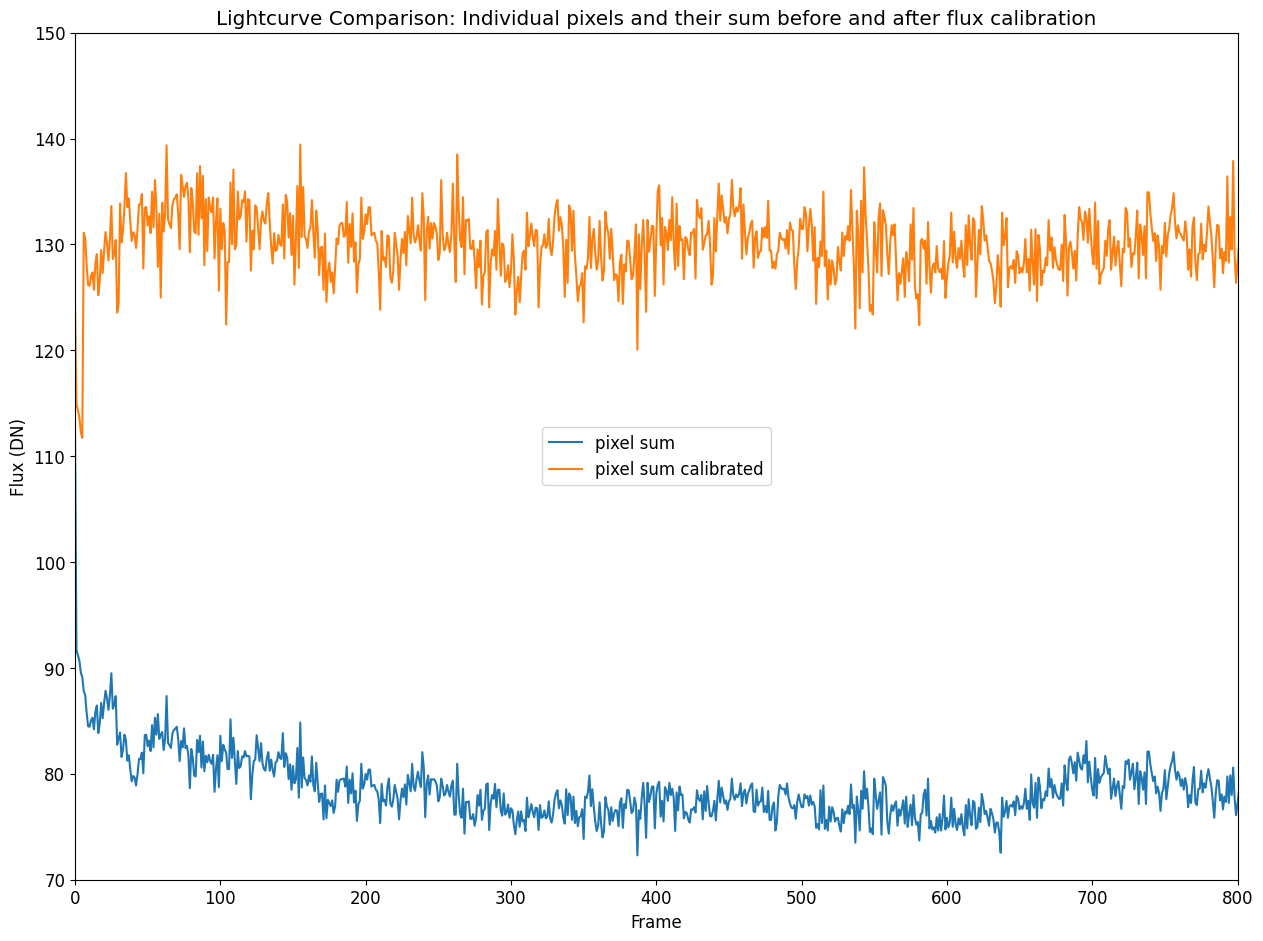

In [20]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(15,11))
#[plt.plot(oF.rolling_average(smoothmono.sum(axis=1)[:,i], 1), label=f"pixel {i}") for i in range(1,3)]
plt.plot(oF.rolling_average(smoothmono.sum(axis=1)[:,1:3].sum(axis=1), 1), label=f"pixel sum")
plt.plot(oF.rolling_average(smoothmono.sum(axis=1)[:,1:3].sum(axis=1)/fluxcal2pix, 1), label=f"pixel sum calibrated")
#plt.plot(oF.rolling_average(smoothmono.sum(axis=1)[:,2]/fluxcal1pix, 1), label=f"pixel 2 corrected")
#plt.plot(fluxcal*7)
plt.legend(loc="center")
plt.ylim(70,150)
plt.xlim(0,800)
plt.axhline(0,0,1500, color="orange")
plt.ylabel("Flux (DN)")
plt.xlabel("Frame")
plt.title("Lightcurve Comparison: Individual pixels and their sum before and after flux calibration")
plt.savefig(outdir + occname + "-fluxmeasurements-preocczoom.png")

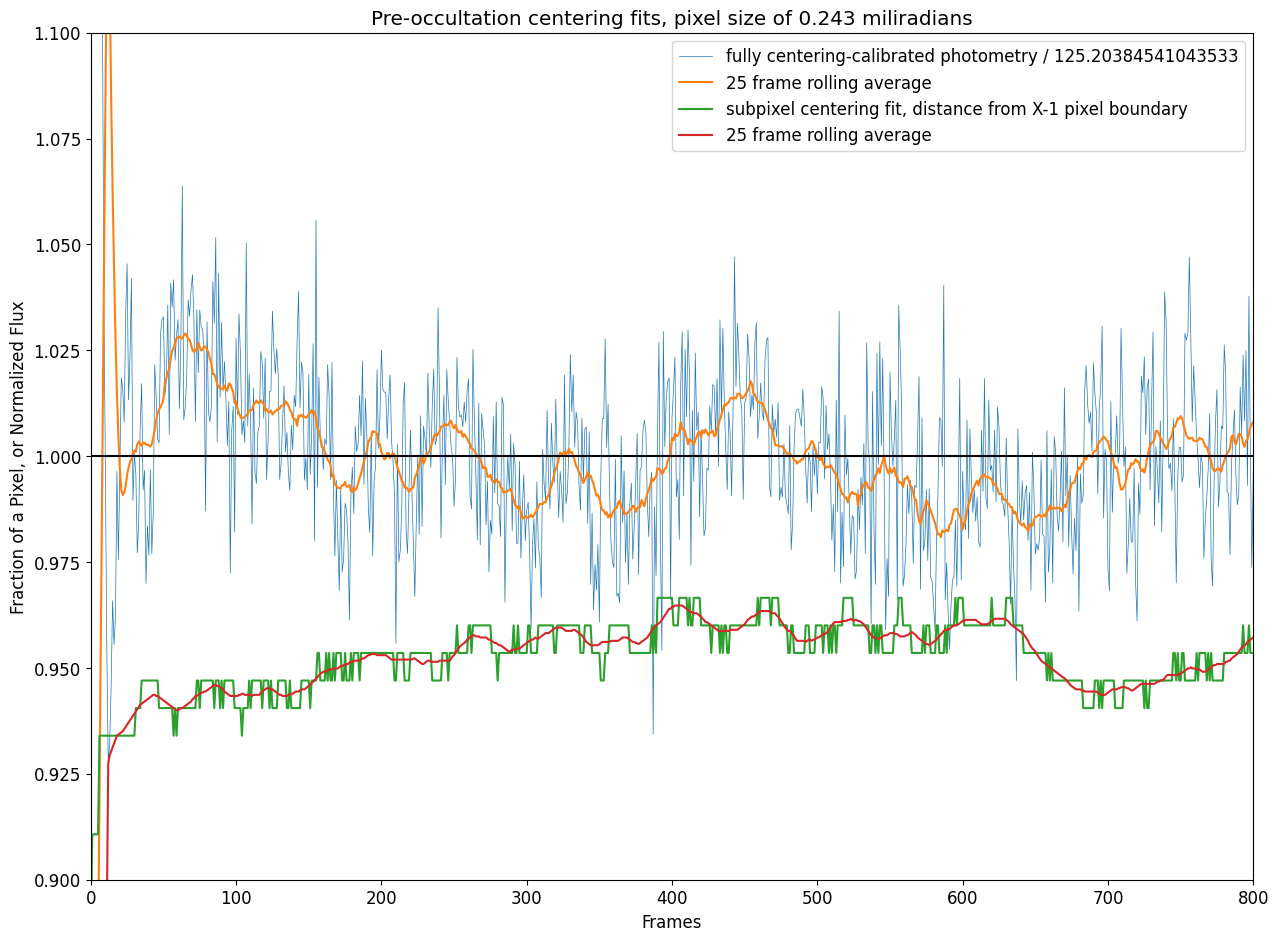

In [50]:
normphot = realphotometry / realphotometry[20:800].mean()
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(15,11))
plt.plot(normphot, linewidth=0.5, label=f"fully centering-calibrated photometry / {realphotometry[20:800].mean()}")
plt.plot(oF.rolling_average(normphot, 25), label="25 frame rolling average")
plt.plot(1-Xcorr, label="subpixel centering fit, distance from X-1 pixel boundary")
#plt.plot(1-Zcorr, label="subpixel centering fit, distance from Z-1 boundary")
plt.plot(oF.rolling_average(1-Xcorr, 25), label="25 frame rolling average")
plt.xlim(0,800)
plt.axhline(1,0,800, color='k')
plt.legend()
plt.ylim(0.9,1.1)
plt.title("Pre-occultation centering fits, pixel size of 0.243 miliradians")
plt.ylabel("Fraction of a Pixel, or Normalized Flux")
plt.xlabel("Frames")
plt.savefig(outdir + occname + "-baselineanalysis-smoothedcalibration-uninterpolatedcentering.png")

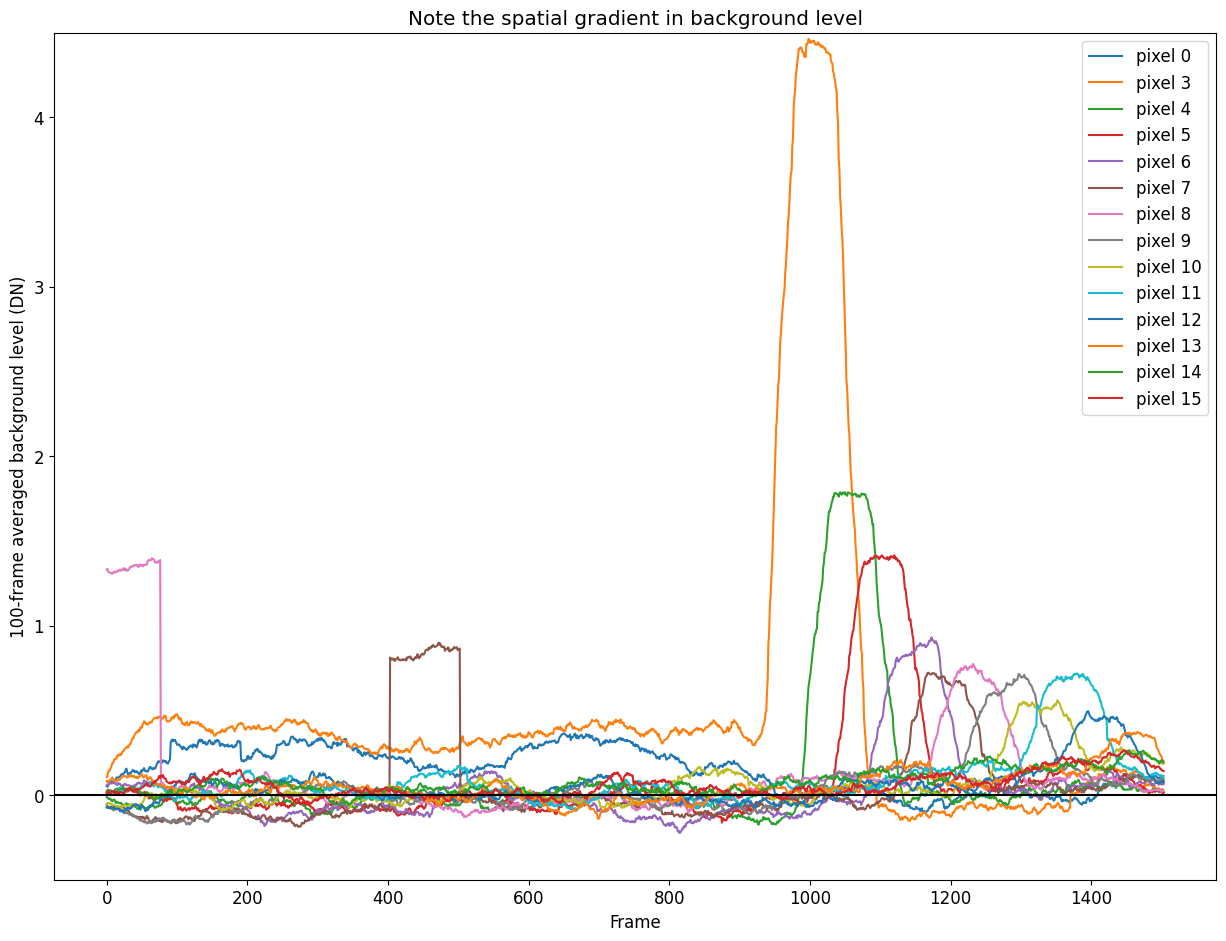

In [22]:
plt.rcParams.update({'font.size': 12})
win=100
plt.figure(figsize=(15,11))
[plt.plot(oF.rolling_average(smoothmono.sum(axis=1)[:,i], win), label=f"pixel {i}") for i in [0,3,4,5,6,7,8,9,10,11,12,13,14,15]]
plt.legend()
plt.ylim(-0.5,4.5)
plt.axhline(0,0,1500, color="k")
plt.ylabel(str(win) + "-frame averaged background level (DN)")
plt.xlabel("Frame")
plt.title("Note the spatial gradient in background level")
plt.savefig(outdir + occname + "-spatial-background-gradient.png")

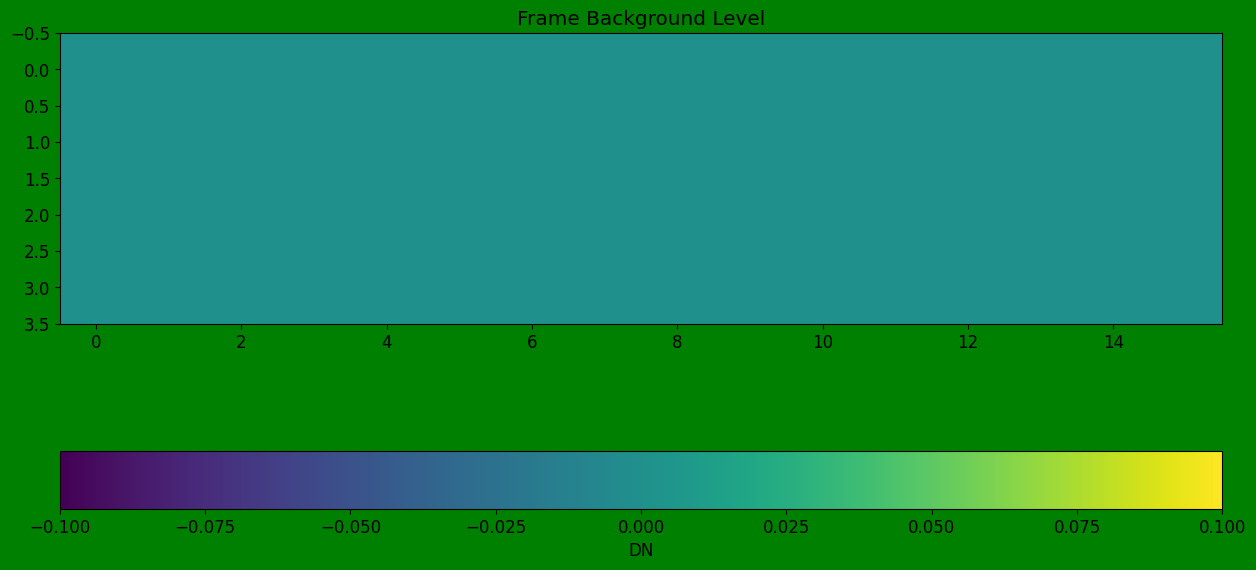

In [23]:
background = np.zeros(smoothmono.shape[1:])
for i in np.arange(np.prod(smoothmono.shape[1:])):
    Z = i%smoothmono.shape[1]
    X = i//smoothmono.shape[1]
    pixel = smoothmono[:,Z,X].copy()
    if X == 0:
        pixel[:1000] = np.nan
    if X == 1:
        pixel[:1000] = np.nan
    if X == 2:
        pixel[:1050] = np.nan
    if X == 3:
        pixel[:1100] = np.nan
    if X == 4:
        pixel[1000:1150] = np.nan
    if X == 5:
        pixel[1050:1150] = np.nan
    if X == 6:
        pixel[1100:1200] = np.nan
    if X == 7:
        pixel[1150:1250] = np.nan
    if X == 8:
        pixel[1150:1300] = np.nan
    if X == 9:
        pixel[1200:1350] = np.nan
    if X == 10:
        pixel[1250:1400] = np.nan
    if X == 11:
        pixel[1300:1450] = np.nan
    if X >= 12:
        pixel[1350:] = np.nan
    background[Z,X] = np.nanmedian(pixel)
    #print(Z,X,background[Z,X])
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(15,11), facecolor="g")
plt.imshow(background)
plt.colorbar(label="DN", location="bottom")
plt.title("Frame Background Level")
plt.savefig(outdir + occname + "background-frame.png")
#np.savetxt("background.csv", background, delimiter=",")

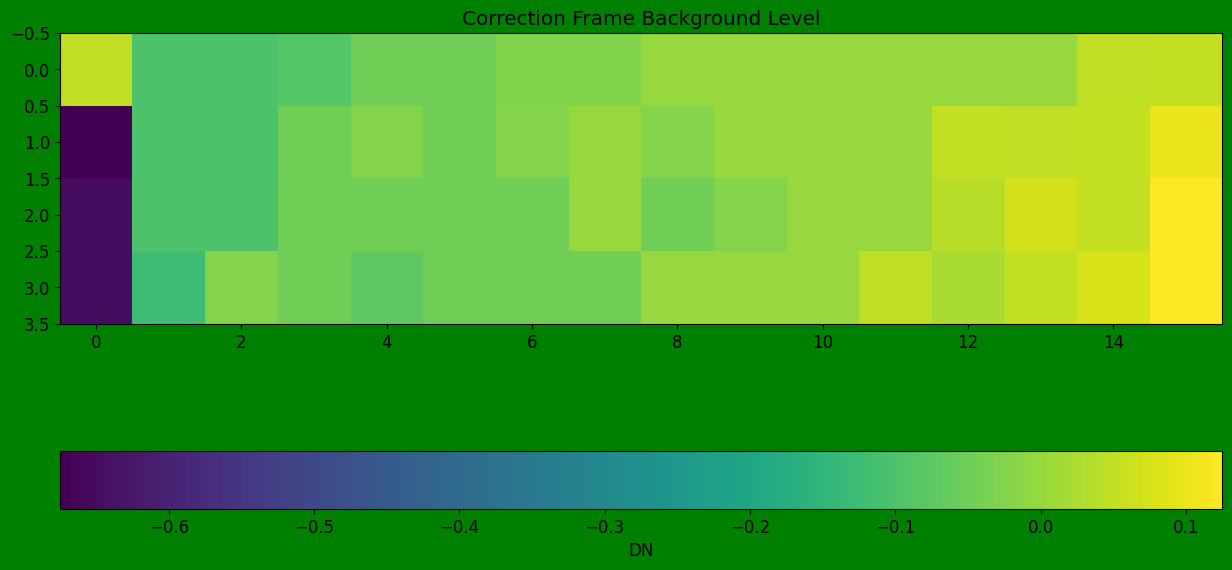

In [24]:
plt.rcParams.update({'font.size': 12})
spatialbackground = np.loadtxt("background.csv", delimiter=',')
plt.figure(figsize=(15,11), facecolor="g")
plt.imshow(spatialbackground)
plt.colorbar(label="DN", location="bottom")
plt.title("Correction Frame Background Level")
plt.savefig(outdir + occname + "correction-background-frame.png")

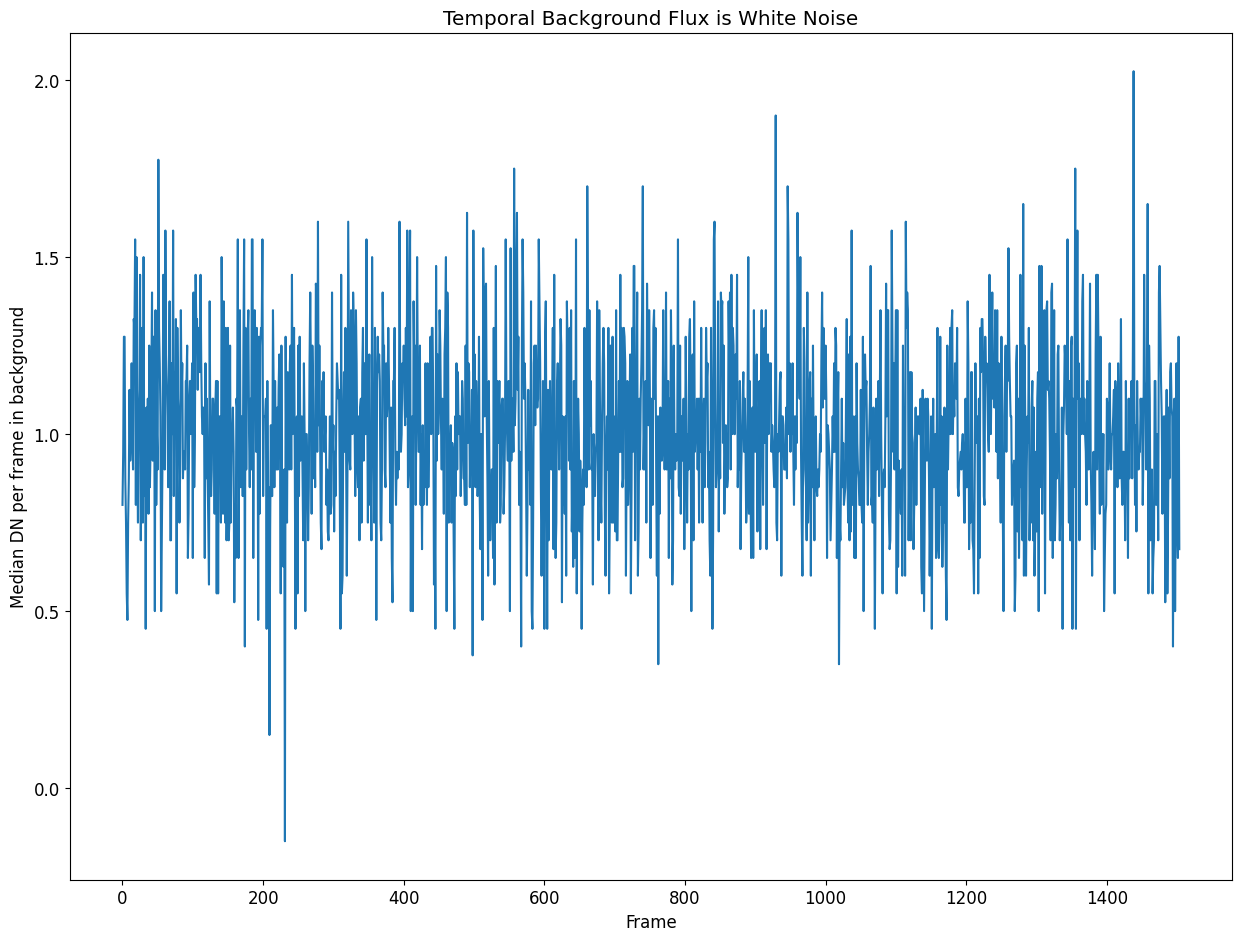

In [25]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(15,11))
plt.plot(bgflux)
#plt.plot(np.fft.fft(bgflux)[1:])
plt.title("Temporal Background Flux is White Noise")
plt.ylabel("Median DN per frame in background")
plt.xlabel("Frame")
plt.savefig(outdir + occname + "background-temporal.png")

(-2.0, 5.0)

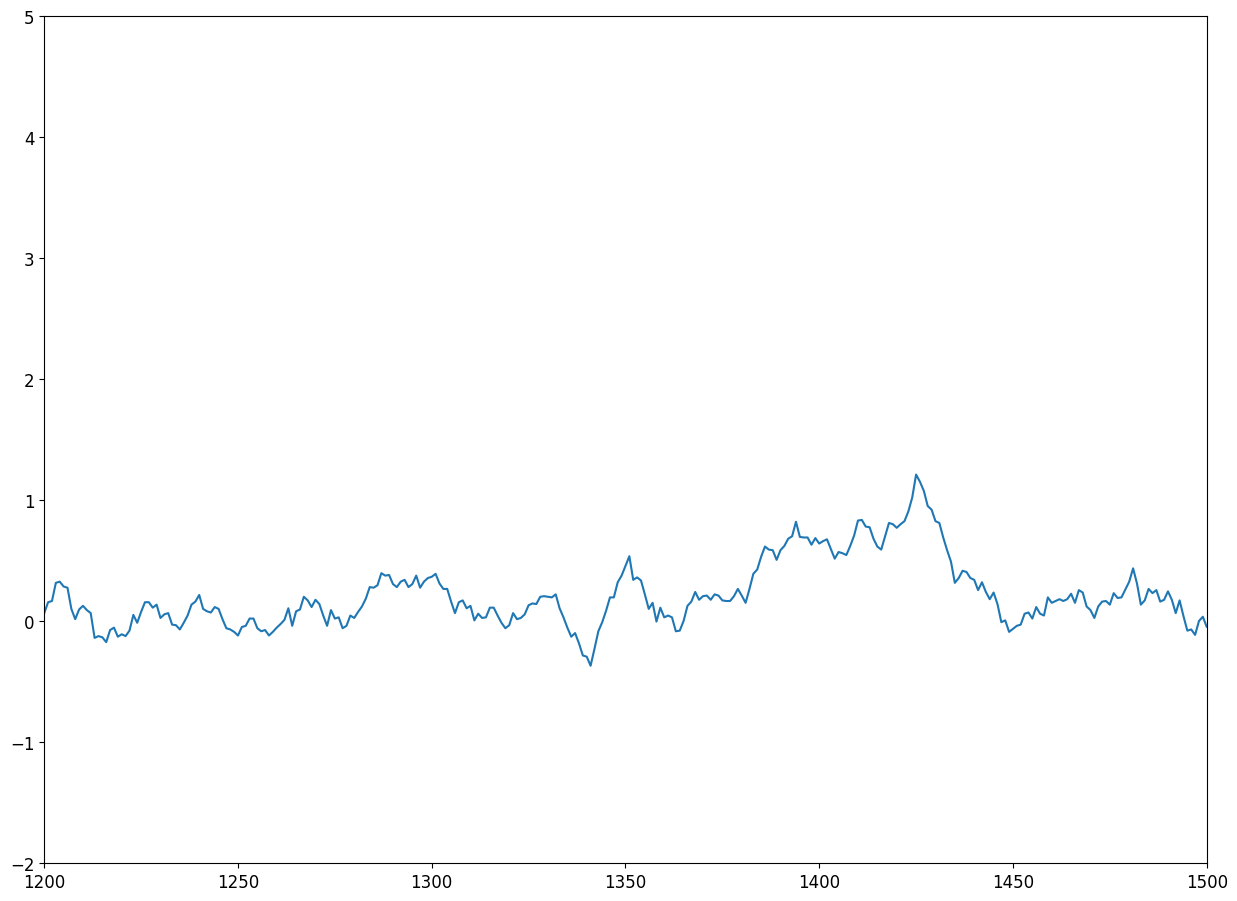

In [26]:
plt.figure(figsize=(15,11))
plt.plot(oF.rolling_average(smoothmono.sum(axis=1)[:,12], 10))
#plt.yscale("log")
plt.xlim(1200,1500)
plt.ylim(-2,5)

In [27]:
#labels = oF.getheaders(cubdir, cubfiles, ncubs)
#label = ps.CubeFile(cubdir+cubfiles[-1]).label

In [28]:
#labels[0]
#label

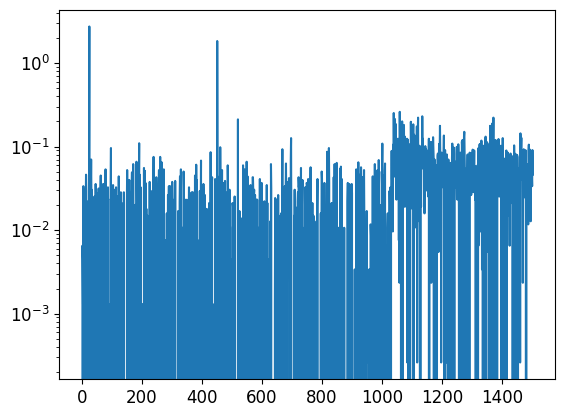

In [29]:
plt.plot(smoothmono[1:,:,4:].mean(axis=1).mean(axis=1))
plt.yscale("log")
#plt.ylim(1e-3,1)

In [30]:
np.prod(smoothmono.shape[1:])

64

In [31]:
#np.savetxt("lightcurvewithgoodbaseline.csv", realphotometry, delimiter=',')

In [32]:
Xmetrics.shape

(567, 21, 5)

In [33]:
Xmetrics[:,9,3]

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
      